In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import matplotlib.gridspec as gridspec
from matplotlib import cm
import string
from numpy import linalg as LA
from scipy.misc import derivative
from scipy.optimize import minimize,root

style.use('seaborn-colorblind')


class agent:
    """
    Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.

        Parameters:
            h1 to h5 (float): relocation rate or hopping rate of the agent at resource level 1 to 5, which comprises the agent's phenotype
            x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
        Functions:
            updatepos(x,y): update the agent's location to (x,y)
    """

    def __init__(self, hop, x, y):

        self.hop = hop
        self.pos = (x, y)
        self.birth = [0, 1, 2, 3, b5]
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def updatepos(self, x, y):
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

# Figure 1: Schematics
## resource distribution & phenotype schematic

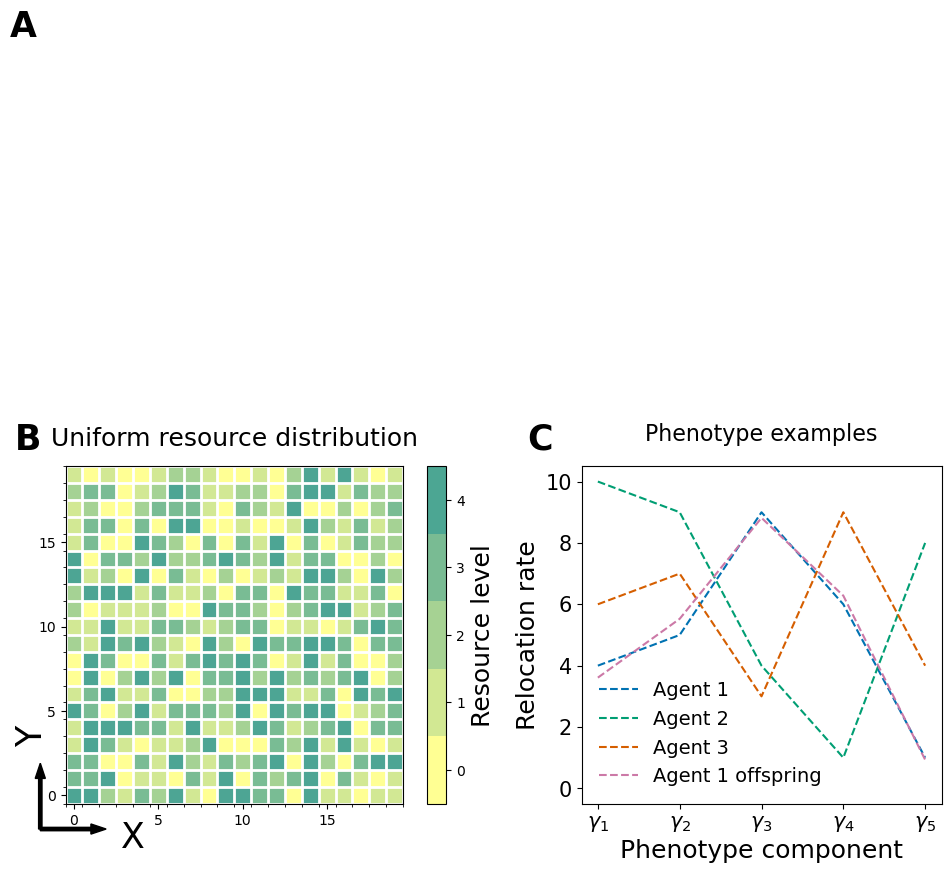

In [2]:
fig = plt.figure(constrained_layout=False, figsize=(9, 7.5),dpi=100)

ax_schematic = plt.subplot(gridspec.GridSpec(1, 1, left=0.1, right=1, top=1, bottom=0.55, wspace=0)[0,0])
ax_schematic.text(-0.15, 1.05, "A", transform=ax_schematic.transAxes,
        size=25, weight='bold')
plt.axis('off')

gs = gridspec.GridSpec(1, 2, width_ratios=[
                       1, 0.05], left=0, right=0.45, top=0.45, bottom=0, wspace=0)
ax = plt.subplot(gs[0, 0])
# Generate data
x = 20
uni_resource = np.random.choice([0, 1, 2, 3, 4],  size=(x, x))
# Major ticks
ax.set_xticks(np.arange(0, x, 5))
ax.set_yticks(np.arange(0, x, 5))
# Labels for major ticks
ax.set_xticklabels(np.arange(0, x, 5))
ax.set_yticklabels(np.arange(0, x, 5))
# Minor ticks
ax.set_xticks(np.arange(-0.5, x, 1), minor=True)
ax.set_yticks(np.arange(-0.5, x, 1), minor=True)
ax.set_xlim(-0.5,19.5)
ax.set_ylim(-0.5,19.5)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
im = ax.imshow(uni_resource[0:x, 0:x], interpolation='none',
               origin='lower', alpha=0.7, cmap=cm.get_cmap('summer_r', 5))
ax.set_title("Uniform resource distribution", fontsize=18, pad=15)
ax.set_xlabel("X", fontsize=25)
ax.set_ylabel("Y", fontsize=25)
ax.arrow(-2, -2, 0, 3, clip_on=False, width=0.2, color='k')
ax.arrow(-2, -2, 3, 0, clip_on=False, width=0.2, color='k')
ax.xaxis.set_label_coords(0.2, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.2)
ax.text(-0.15, 1.05, "B", transform=ax.transAxes,
        size=25, weight='bold')
# Color bar axis
ax_cb = plt.subplot(gs[0, 1])
cbar = plt.colorbar(im, cax=ax_cb, ticks=[0, 1, 2, 3, 4])
cbar.mappable.set_clim(-0.5, 4.5)
cbar.set_label('Resource level', fontsize=18)


# Phenotype schematic
gs2 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0.6, right=1, top=0.45, bottom=0, wspace=0)
ax2 = plt.subplot(gs2[0, 0])
hop = [[4, 5, 9, 6, 1], [10, 9, 4, 1, 8], [6, 7, 3, 9, 4], np.array(
    [4, 5, 9, 6, 1])+np.random.normal(0, 0.3, 5)]  # size of reproduction noise is for illustration purpose only
for i in range(3):
    ax2.plot(hop[i], '--', label='Agent {}'.format(i+1))
ax2.plot(hop[3], '--', label='Agent 1 offspring')
ax2.set_title("Phenotype examples",
              fontsize=16, pad=18)
ax2.text(-0.15, 1.05, "C", transform=ax2.transAxes,
         size=25, weight='bold')
plt.xticks(np.arange(5), ('$\gamma_1$', r'$\gamma_2$',
                          r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Relocation rate', fontsize=18)
plt.xlabel('Phenotype component', fontsize=18)
plt.ylim(-0.5, 10.5)
plt.legend(loc=3, fontsize=14, frameon=False)

fig.savefig('./Figures/Figure_1_resource_phenotype.pdf', bbox_inches='tight') # save the figure!

# Figure 2: Stochastic dynamics
## Violin plots at iterations 0, 50, 500, 20000


In [3]:
# mean field data for b5=5, takes 21 mins to run
t_eval = np.linspace(0, 200, 200)
ave_meanfield=np.array([[5.00000000e+00, 5.00000000e+00, 5.00000000e+00, 5.00000000e+00,
        5.00000000e+00],
       [5.65302259e+00, 5.37429212e+00, 5.08111162e+00, 4.77392962e+00,
        4.11999334e+00],
       [6.28927098e+00, 5.81864274e+00, 5.26131818e+00, 4.61285811e+00,
        3.05263833e+00],
       [6.75569946e+00, 6.21492749e+00, 5.50117345e+00, 4.57927794e+00,
        2.11908754e+00],
       [7.11646077e+00, 6.55707220e+00, 5.75814412e+00, 4.62791111e+00,
        1.39983678e+00],
       [7.41126116e+00, 6.85233555e+00, 6.00810378e+00, 4.71535727e+00,
        8.97546757e-01],
       [7.66015010e+00, 7.10882384e+00, 6.24082977e+00, 4.81346286e+00,
        5.68906413e-01],
       [7.87470235e+00, 7.33361296e+00, 6.45431385e+00, 4.90924379e+00,
        3.61130592e-01],
       [8.06159641e+00, 7.53173492e+00, 6.64915524e+00, 4.99908682e+00,
        2.31390964e-01],
       [8.22555718e+00, 7.70724343e+00, 6.82672287e+00, 5.08271059e+00,
        1.50246470e-01],
       [8.37083731e+00, 7.86411369e+00, 6.98920387e+00, 5.16110545e+00,
        9.89483223e-02],
       [8.50053221e+00, 8.00532120e+00, 7.13851559e+00, 5.23562908e+00,
        6.60201870e-02],
       [8.61641455e+00, 8.13279819e+00, 7.27579689e+00, 5.30711801e+00,
        4.45731111e-02],
       [8.72049913e+00, 8.24854552e+00, 7.40236534e+00, 5.37631717e+00,
        3.04043004e-02],
       [8.81470963e+00, 8.35431898e+00, 7.51967986e+00, 5.44404931e+00,
        2.09128272e-02],
       [8.90005809e+00, 8.45117015e+00, 7.62858813e+00, 5.51033920e+00,
        1.44828666e-02],
       [8.97753345e+00, 8.54008381e+00, 7.72983151e+00, 5.57526831e+00,
        1.00870851e-02],
       [9.04835530e+00, 8.62216034e+00, 7.82436326e+00, 5.63926407e+00,
        7.05603067e-03],
       [9.11316147e+00, 8.69809397e+00, 7.91290569e+00, 5.70237434e+00,
        4.95279797e-03],
       [9.17243492e+00, 8.76835940e+00, 7.99580512e+00, 5.76431757e+00,
        3.48668576e-03],
       [9.22707834e+00, 8.83370982e+00, 8.07370811e+00, 5.82529406e+00,
        2.45977778e-03],
       [9.27749713e+00, 8.89458958e+00, 8.14712502e+00, 5.88561048e+00,
        1.73804449e-03],
       [9.32389074e+00, 8.95130064e+00, 8.21642929e+00, 5.94481304e+00,
        1.22992019e-03],
       [9.36684866e+00, 9.00435571e+00, 8.28185678e+00, 6.00296736e+00,
        8.71197630e-04],
       [9.40679498e+00, 9.05405426e+00, 8.34381373e+00, 6.06031480e+00,
        6.17536839e-04],
       [9.44375811e+00, 9.10055680e+00, 8.40254499e+00, 6.11669166e+00,
        4.37997202e-04],
       [9.47804503e+00, 9.14433309e+00, 8.45832164e+00, 6.17200784e+00,
        3.10793040e-04],
       [9.51009143e+00, 9.18552066e+00, 8.51130542e+00, 6.22624042e+00,
        2.20599688e-04],
       [9.53993629e+00, 9.22414655e+00, 8.56175578e+00, 6.27965879e+00,
        1.56610481e-04],
       [9.56769650e+00, 9.26063488e+00, 8.60982268e+00, 6.33198469e+00,
        1.11202100e-04],
       [9.59360617e+00, 9.29515852e+00, 8.65560357e+00, 6.38327653e+00,
        7.89602427e-05],
       [9.61794942e+00, 9.32763287e+00, 8.69931644e+00, 6.43364494e+00,
        5.60739360e-05],
       [9.64064355e+00, 9.35833046e+00, 8.74120205e+00, 6.48295743e+00,
        3.98191784e-05],
       [9.66183611e+00, 9.38753773e+00, 8.78108529e+00, 6.53119675e+00,
        2.82726802e-05],
       [9.68175091e+00, 9.41509120e+00, 8.81926253e+00, 6.57872410e+00,
        2.00749080e-05],
       [9.70040160e+00, 9.44117328e+00, 8.85601351e+00, 6.62494286e+00,
        1.42525873e-05],
       [9.71788268e+00, 9.46599236e+00, 8.89113124e+00, 6.67012085e+00,
        1.01184459e-05],
       [9.73433393e+00, 9.48949525e+00, 8.92470551e+00, 6.71468696e+00,
        7.18195547e-06],
       [9.74971673e+00, 9.51186626e+00, 8.95713183e+00, 6.75822298e+00,
        5.09786058e-06],
       [9.76420594e+00, 9.53306452e+00, 8.98819528e+00, 6.80044805e+00,
        3.61833324e-06],
       [9.77783161e+00, 9.55329543e+00, 9.01796890e+00, 6.84222727e+00,
        2.56743247e-06],
       [9.79063263e+00, 9.57253260e+00, 9.04665577e+00, 6.88309718e+00,
        1.82175427e-06],
       [9.80266793e+00, 9.59085311e+00, 9.07437317e+00, 6.92272450e+00,
        1.29237570e-06],
       [9.81401908e+00, 9.60830560e+00, 9.10095995e+00, 6.96199625e+00,
        9.16859182e-07],
       [9.82465731e+00, 9.62488098e+00, 9.12647675e+00, 6.99985514e+00,
        6.50385941e-07],
       [9.83472553e+00, 9.64083693e+00, 9.15132557e+00, 7.03754547e+00,
        4.61282403e-07],
       [9.84414140e+00, 9.65584744e+00, 9.17504447e+00, 7.07391969e+00,
        3.27167564e-07],
       [9.85308337e+00, 9.67039403e+00, 9.19807649e+00, 7.10988869e+00,
        2.31982296e-07],
       [9.86144733e+00, 9.68411463e+00, 9.22019549e+00, 7.14492646e+00,
        1.64511363e-07],
       [9.86937140e+00, 9.69733320e+00, 9.24161048e+00, 7.17898800e+00,
        1.16637462e-07],
       [9.87679223e+00, 9.70984419e+00, 9.26223488e+00, 7.21290770e+00,
        8.27055111e-08],
       [9.88383383e+00, 9.72193726e+00, 9.28227804e+00, 7.24567074e+00,
        5.86249545e-08],
       [9.89045658e+00, 9.73336811e+00, 9.30164095e+00, 7.27809189e+00,
        4.15645916e-08],
       [9.89666179e+00, 9.74432426e+00, 9.32014860e+00, 7.30919757e+00,
        2.94697645e-08],
       [9.90256227e+00, 9.75488975e+00, 9.33835385e+00, 7.34046365e+00,
        2.08864769e-08],
       [9.90809200e+00, 9.76489480e+00, 9.35574176e+00, 7.37038535e+00,
        1.48050052e-08],
       [9.91333876e+00, 9.77455010e+00, 9.37272630e+00, 7.40030198e+00,
        1.04943792e-08],
       [9.91824363e+00, 9.78368260e+00, 9.38901128e+00, 7.42906811e+00,
        7.43920066e-09],
       [9.92291872e+00, 9.79258086e+00, 9.40501753e+00, 7.45781158e+00,
        5.27184842e-09],
       [9.92727025e+00, 9.80092058e+00, 9.42029058e+00, 7.48551883e+00,
        3.73744113e-09],
       [9.93142574e+00, 9.80907383e+00, 9.43518020e+00, 7.51268166e+00,
        2.64896812e-09],
       [9.93532049e+00, 9.81677475e+00, 9.44969578e+00, 7.53991878e+00,
        1.87726728e-09],
       [9.93900185e+00, 9.82421631e+00, 9.46365918e+00, 7.56591261e+00,
        1.33056338e-09],
       [9.94246106e+00, 9.83127371e+00, 9.47729797e+00, 7.59199971e+00,
        9.43054702e-10],
       [9.94574568e+00, 9.83812693e+00, 9.49044303e+00, 7.61684072e+00,
        6.68422362e-10],
       [9.94882696e+00, 9.84463462e+00, 9.50328039e+00, 7.64215392e+00,
        4.73757082e-10],
       [9.95173097e+00, 9.85087713e+00, 9.51560245e+00, 7.66590931e+00,
        3.35836710e-10],
       [9.95448934e+00, 9.85689931e+00, 9.52777945e+00, 7.69013447e+00,
        2.38020046e-10],
       [9.95706982e+00, 9.86262477e+00, 9.53944258e+00, 7.71347311e+00,
        1.68725611e-10],
       [9.95952153e+00, 9.86816853e+00, 9.55087254e+00, 7.73684170e+00,
        1.19578058e-10],
       [9.96181354e+00, 9.87341132e+00, 9.56189981e+00, 7.75917797e+00,
        8.47735512e-11],
       [9.96400458e+00, 9.87854799e+00, 9.57269272e+00, 7.78136342e+00,
        6.00811975e-11],
       [9.96604437e+00, 9.88335866e+00, 9.58311955e+00, 7.80359327e+00,
        4.25984324e-11],
       [9.96798090e+00, 9.88805916e+00, 9.59319972e+00, 7.82430666e+00,
        3.01990245e-11],
       [9.96980193e+00, 9.89251653e+00, 9.60323030e+00, 7.84595838e+00,
        2.14076652e-11],
       [9.97153011e+00, 9.89684177e+00, 9.61274914e+00, 7.86634232e+00,
        1.51783524e-11],
       [9.97315400e+00, 9.90095604e+00, 9.62216989e+00, 7.88721762e+00,
        1.07588655e-11],
       [9.97467787e+00, 9.90491081e+00, 9.63114024e+00, 7.90650713e+00,
        7.62995912e-12],
       [9.97612033e+00, 9.90870870e+00, 9.64011490e+00, 7.92681890e+00,
        5.40937496e-12],
       [9.97748776e+00, 9.91235006e+00, 9.64869041e+00, 7.94588377e+00,
        3.83607520e-12],
       [9.97877460e+00, 9.91585603e+00, 9.65709884e+00, 7.96500984e+00,
        2.71971755e-12],
       [9.97997761e+00, 9.91919604e+00, 9.66522895e+00, 7.98361980e+00,
        1.92923039e-12],
       [9.98112542e+00, 9.92244360e+00, 9.67322297e+00, 8.00232843e+00,
        1.36793850e-12],
       [9.98220219e+00, 9.92552314e+00, 9.68096319e+00, 8.02047751e+00,
        9.70228164e-13],
       [9.98321796e+00, 9.92849543e+00, 9.68841695e+00, 8.03783842e+00,
        6.88143082e-13],
       [9.98417479e+00, 9.93134170e+00, 9.69590384e+00, 8.05606295e+00,
        4.88102959e-13],
       [9.98508347e+00, 9.93410539e+00, 9.70299917e+00, 8.07283230e+00,
        3.46162746e-13],
       [9.98593262e+00, 9.93670740e+00, 9.70999727e+00, 8.09052393e+00,
        2.45583720e-13],
       [9.98673683e+00, 9.93924131e+00, 9.71672189e+00, 8.10661700e+00,
        1.74229354e-13],
       [9.98749389e+00, 9.94165831e+00, 9.72347342e+00, 8.12374312e+00,
        1.23598238e-13],
       [9.98820897e+00, 9.94398698e+00, 9.72982655e+00, 8.13955689e+00,
        8.77011795e-14],
       [9.98888268e+00, 9.94621902e+00, 9.73616902e+00, 8.15588315e+00,
        6.22274946e-14],
       [9.98951831e+00, 9.94836510e+00, 9.74234360e+00, 8.17178690e+00,
        4.41468756e-14],
       [9.99011765e+00, 9.95042425e+00, 9.74832042e+00, 8.18739432e+00,
        3.13241603e-14],
       [9.99068200e+00, 9.95239418e+00, 9.75410059e+00, 8.20288949e+00,
        2.22317962e-14],
       [9.99121661e+00, 9.95430120e+00, 9.75982059e+00, 8.21763403e+00,
        1.57787248e-14],
       [9.99171793e+00, 9.95611660e+00, 9.76543614e+00, 8.23304561e+00,
        1.11971072e-14],
       [9.99219000e+00, 9.95786536e+00, 9.77074681e+00, 8.24715686e+00,
        7.94952767e-15],
       [9.99263787e+00, 9.95954433e+00, 9.77612655e+00, 8.26225397e+00,
        5.64138750e-15],
       [9.99305983e+00, 9.96116343e+00, 9.78119102e+00, 8.27623266e+00,
        4.00509894e-15],
       [9.99345695e+00, 9.96270837e+00, 9.78632635e+00, 8.29094568e+00,
        2.84242518e-15],
       [9.99383106e+00, 9.96420434e+00, 9.79114986e+00, 8.30427744e+00,
        2.01822963e-15],
       [9.99418342e+00, 9.96562630e+00, 9.79601394e+00, 8.31840635e+00,
        1.43274057e-15],
       [9.99451785e+00, 9.96699940e+00, 9.80067428e+00, 8.33185731e+00,
        1.01732897e-15],
       [9.99482958e+00, 9.96830445e+00, 9.80518821e+00, 8.34506345e+00,
        7.22520376e-16],
       [9.99512675e+00, 9.96958251e+00, 9.80967096e+00, 8.35875864e+00,
        5.12939094e-16],
       [9.99540557e+00, 9.97079329e+00, 9.81401520e+00, 8.37158493e+00,
        3.64293820e-16],
       [9.99566933e+00, 9.97195982e+00, 9.81831226e+00, 8.38485415e+00,
        2.58620624e-16],
       [9.99591574e+00, 9.97307733e+00, 9.82239247e+00, 8.39683057e+00,
        1.83746723e-16],
       [9.99615015e+00, 9.97415233e+00, 9.82647590e+00, 8.41000148e+00,
        1.30467274e-16],
       [9.99637124e+00, 9.97518613e+00, 9.83037321e+00, 8.42202081e+00,
        9.26924917e-17],
       [9.99657871e+00, 9.97617216e+00, 9.83432533e+00, 8.43471499e+00,
        6.58234738e-17],
       [9.99677405e+00, 9.97712845e+00, 9.83799214e+00, 8.44633272e+00,
        4.67787817e-17],
       [9.99695905e+00, 9.97804068e+00, 9.84173891e+00, 8.45890890e+00,
        3.32176882e-17],
       [9.99713361e+00, 9.97891799e+00, 9.84529464e+00, 8.47044261e+00,
        2.36073395e-17],
       [9.99729722e+00, 9.97975458e+00, 9.84880352e+00, 8.48194741e+00,
        1.67674644e-17],
       [9.99745262e+00, 9.98057540e+00, 9.85223576e+00, 8.49387438e+00,
        1.19148126e-17],
       [9.99759761e+00, 9.98134263e+00, 9.85558268e+00, 8.50496026e+00,
        8.46535604e-18],
       [9.99773628e+00, 9.98209246e+00, 9.85888542e+00, 8.51651681e+00,
        6.01616193e-18],
       [9.99786521e+00, 9.98280555e+00, 9.86203694e+00, 8.52723505e+00,
        4.27545178e-18],
       [9.99798792e+00, 9.98349597e+00, 9.86519206e+00, 8.53882264e+00,
        3.03772889e-18],
       [9.99810234e+00, 9.98415148e+00, 9.86817125e+00, 8.54907566e+00,
        2.15947702e-18],
       [9.99821181e+00, 9.98478507e+00, 9.87121961e+00, 8.56028357e+00,
        1.53447994e-18],
       [9.99831414e+00, 9.98539698e+00, 9.87409050e+00, 8.57070346e+00,
        1.09056663e-18],
       [9.99841062e+00, 9.98597983e+00, 9.87698279e+00, 8.58150265e+00,
        7.75157112e-19],
       [9.99850177e+00, 9.98654215e+00, 9.87971046e+00, 8.59145127e+00,
        5.51120154e-19],
       [9.99858746e+00, 9.98707810e+00, 9.88243261e+00, 8.60200490e+00,
        3.91717949e-19],
       [9.99866856e+00, 9.98759796e+00, 9.88506400e+00, 8.61237668e+00,
        2.78477103e-19],
       [9.99874422e+00, 9.98808666e+00, 9.88765267e+00, 8.62185885e+00,
        1.97999325e-19],
       [9.99881686e+00, 9.98857042e+00, 9.89021381e+00, 8.63228562e+00,
        1.40754255e-19],
       [9.99888432e+00, 9.98902443e+00, 9.89266400e+00, 8.64185045e+00,
        1.00059771e-19],
       [9.99894864e+00, 9.98946692e+00, 9.89511206e+00, 8.65198813e+00,
        7.11417933e-20],
       [9.99900824e+00, 9.98988669e+00, 9.89742743e+00, 8.66101637e+00,
        5.05927930e-20],
       [9.99906551e+00, 9.99029208e+00, 9.89977568e+00, 8.67103278e+00,
        3.59751162e-20],
       [9.99911891e+00, 9.99067880e+00, 9.90199940e+00, 8.68019312e+00,
        2.55801784e-20],
       [9.99916922e+00, 9.99105086e+00, 9.90422086e+00, 8.68948642e+00,
        1.81966511e-20],
       [9.99921676e+00, 9.99141269e+00, 9.90635678e+00, 8.69886807e+00,
        1.29355014e-20],
       [9.99926193e+00, 9.99175494e+00, 9.90848467e+00, 8.70812755e+00,
        9.20088533e-21],
       [9.99930425e+00, 9.99208606e+00, 9.91052728e+00, 8.71706284e+00,
        6.54193453e-21],
       [9.99934379e+00, 9.99239976e+00, 9.91253653e+00, 8.72570330e+00,
        4.65497311e-21],
       [9.99938164e+00, 9.99270885e+00, 9.91450990e+00, 8.73497937e+00,
        3.30976407e-21],
       [9.99941683e+00, 9.99299628e+00, 9.91641455e+00, 8.74326313e+00,
        2.35523992e-21],
       [9.99945053e+00, 9.99328041e+00, 9.91831988e+00, 8.75251543e+00,
        1.67448397e-21],
       [9.99948171e+00, 9.99354698e+00, 9.92011343e+00, 8.76052611e+00,
        1.19160300e-21],
       [9.99951171e+00, 9.99380826e+00, 9.92195348e+00, 8.76945780e+00,
        8.47162147e-22],
       [9.99953940e+00, 9.99405290e+00, 9.92366744e+00, 8.77768257e+00,
        6.03038365e-22],
       [9.99956598e+00, 9.99429294e+00, 9.92540715e+00, 8.78598015e+00,
        4.28877570e-22],
       [9.99959079e+00, 9.99452290e+00, 9.92708079e+00, 8.79429859e+00,
        3.05109041e-22],
       [9.99961428e+00, 9.99474121e+00, 9.92872431e+00, 8.80257376e+00,
        2.17078888e-22],
       [9.99963638e+00, 9.99495243e+00, 9.93029919e+00, 8.81069101e+00,
        1.54455241e-22],
       [9.99965714e+00, 9.99515342e+00, 9.93187428e+00, 8.81842214e+00,
        1.09905346e-22],
       [9.99967680e+00, 9.99535011e+00, 9.93340979e+00, 8.82678482e+00,
        7.81756367e-23],
       [9.99969522e+00, 9.99553255e+00, 9.93488021e+00, 8.83415610e+00,
        5.56514996e-23],
       [9.99971286e+00, 9.99571481e+00, 9.93636672e+00, 8.84210555e+00,
        3.95802960e-23],
       [9.99972918e+00, 9.99588509e+00, 9.93778419e+00, 8.84972112e+00,
        2.81719410e-23],
       [9.99974478e+00, 9.99605151e+00, 9.93920007e+00, 8.85781081e+00,
        2.00425531e-23],
       [9.99975930e+00, 9.99620829e+00, 9.94053378e+00, 8.86479204e+00,
        1.42686757e-23],
       [9.99977321e+00, 9.99636141e+00, 9.94189262e+00, 8.87265907e+00,
        1.01489508e-23],
       [9.99978612e+00, 9.99650610e+00, 9.94318835e+00, 8.88007659e+00,
        7.22519069e-24],
       [9.99979837e+00, 9.99664616e+00, 9.94445229e+00, 8.88704916e+00,
        5.14146720e-24],
       [9.99980993e+00, 9.99678192e+00, 9.94570135e+00, 8.89468826e+00,
        3.65898791e-24],
       [9.99982087e+00, 9.99691005e+00, 9.94693895e+00, 8.90184490e+00,
        2.60387972e-24],
       [9.99983111e+00, 9.99703472e+00, 9.94812181e+00, 8.90924749e+00,
        1.85347860e-24],
       [9.99984075e+00, 9.99715223e+00, 9.94927009e+00, 8.91574344e+00,
        1.31928958e-24],
       [9.99984989e+00, 9.99726766e+00, 9.95041843e+00, 8.92326851e+00,
        9.39085944e-25],
       [9.99985847e+00, 9.99737605e+00, 9.95152749e+00, 8.92986479e+00,
        6.68249061e-25],
       [9.99986661e+00, 9.99748298e+00, 9.95262812e+00, 8.93691385e+00,
        4.75706657e-25],
       [9.99987420e+00, 9.99758241e+00, 9.95366838e+00, 8.94371435e+00,
        3.38624643e-25],
       [9.99988149e+00, 9.99768028e+00, 9.95474017e+00, 8.95069309e+00,
        2.41025490e-25],
       [9.99988822e+00, 9.99777254e+00, 9.95574225e+00, 8.95719364e+00,
        1.71554673e-25],
       [9.99989463e+00, 9.99786238e+00, 9.95672775e+00, 8.96377461e+00,
        1.22166306e-25],
       [9.99990066e+00, 9.99794820e+00, 9.95770007e+00, 8.97069431e+00,
        8.69375929e-26],
       [9.99990638e+00, 9.99802997e+00, 9.95865837e+00, 8.97686455e+00,
        6.18983586e-26],
       [9.99991173e+00, 9.99810980e+00, 9.95958367e+00, 8.98370760e+00,
        4.40479970e-26],
       [9.99991677e+00, 9.99818472e+00, 9.96048411e+00, 8.98981997e+00,
        3.13731988e-26],
       [9.99992155e+00, 9.99825838e+00, 9.96138340e+00, 8.99641347e+00,
        2.23259692e-26],
       [9.99992604e+00, 9.99832718e+00, 9.96223856e+00, 9.00242003e+00,
        1.59004634e-26],
       [9.99993027e+00, 9.99839512e+00, 9.96308738e+00, 9.00895186e+00,
        1.13198957e-26],
       [9.99993428e+00, 9.99845936e+00, 9.96392148e+00, 9.01502118e+00,
        8.05689434e-27],
       [9.99993804e+00, 9.99852141e+00, 9.96474354e+00, 9.02137978e+00,
        5.73661933e-27],
       [9.99994158e+00, 9.99857999e+00, 9.96551916e+00, 9.02734773e+00,
        4.08430699e-27],
       [9.99994493e+00, 9.99863777e+00, 9.96629960e+00, 9.03328949e+00,
        2.90839557e-27],
       [9.99994808e+00, 9.99869195e+00, 9.96705266e+00, 9.03955390e+00,
        2.07006353e-27],
       [9.99995105e+00, 9.99874412e+00, 9.96778793e+00, 9.04516480e+00,
        1.47491142e-27],
       [9.99995386e+00, 9.99879494e+00, 9.96851709e+00, 9.05130969e+00,
        1.04960893e-27],
       [9.99995651e+00, 9.99884322e+00, 9.96922755e+00, 9.05691608e+00,
        7.47563191e-28],
       [9.99995900e+00, 9.99888974e+00, 9.96992028e+00, 9.06320587e+00,
        5.32047331e-28],
       [9.99996135e+00, 9.99893382e+00, 9.97059143e+00, 9.06843901e+00,
        3.79092973e-28],
       [9.99996356e+00, 9.99897711e+00, 9.97125518e+00, 9.07434641e+00,
        2.69745876e-28],
       [9.99996565e+00, 9.99901779e+00, 9.97189522e+00, 9.08007144e+00,
        1.92170389e-28],
       [9.99996760e+00, 9.99905738e+00, 9.97253056e+00, 9.08537813e+00,
        1.36836409e-28],
       [9.99996947e+00, 9.99909508e+00, 9.97315039e+00, 9.09120234e+00,
        9.74386037e-29],
       [9.99997122e+00, 9.99913168e+00, 9.97375630e+00, 9.09679335e+00,
        6.93647680e-29],
       [9.99997287e+00, 9.99916626e+00, 9.97434047e+00, 9.10234873e+00,
        4.94021153e-29],
       [9.99997441e+00, 9.99919977e+00, 9.97491982e+00, 9.10732972e+00,
        3.51770832e-29],
       [9.99997589e+00, 9.99923186e+00, 9.97548505e+00, 9.11313116e+00,
        2.50516516e-29],
       [9.99997726e+00, 9.99926253e+00, 9.97603034e+00, 9.11819965e+00,
        1.78417928e-29],
       [9.99997857e+00, 9.99929238e+00, 9.97657680e+00, 9.12379081e+00,
        1.27030028e-29],
       [9.99997979e+00, 9.99932050e+00, 9.97709849e+00, 9.12885137e+00,
        9.04968183e-30],
       [9.99998095e+00, 9.99934790e+00, 9.97761610e+00, 9.13415868e+00,
        6.44193683e-30]])
std_meanfield=np.array([[3.41565026e+00, 3.41565026e+00, 3.41565026e+00, 3.41565026e+00,
        3.41565026e+00],
       [3.28642911e+00, 3.35392782e+00, 3.40561661e+00, 3.43893598e+00,
        3.43917458e+00],
       [3.06007819e+00, 3.23235077e+00, 3.37537617e+00, 3.45883344e+00,
        3.27973645e+00],
       [2.85532747e+00, 3.09431598e+00, 3.32376540e+00, 3.46732460e+00,
        2.91544295e+00],
       [2.67797868e+00, 2.95431245e+00, 3.25543442e+00, 3.46840764e+00,
        2.44233614e+00],
       [2.52091122e+00, 2.81877592e+00, 3.17682964e+00, 3.46339717e+00,
        1.96157603e+00],
       [2.38012655e+00, 2.69061579e+00, 3.09317399e+00, 3.45388293e+00,
        1.53657406e+00],
       [2.25294952e+00, 2.57095185e+00, 3.00793976e+00, 3.44166738e+00,
        1.18988281e+00],
       [2.13738833e+00, 2.46012142e+00, 2.92342759e+00, 3.42836805e+00,
        9.19531143e-01],
       [2.03194289e+00, 2.35792846e+00, 2.84103791e+00, 3.41480658e+00,
        7.13508204e-01],
       [1.93523306e+00, 2.26361711e+00, 2.76136418e+00, 3.40088746e+00,
        5.57776450e-01],
       [1.84593404e+00, 2.17612731e+00, 2.68464353e+00, 3.38669518e+00,
        4.39909855e-01],
       [1.76330570e+00, 2.09478774e+00, 2.61129082e+00, 3.37244920e+00,
        3.50218641e-01],
       [1.68674082e+00, 2.01903934e+00, 2.54143145e+00, 3.35784937e+00,
        2.81367373e-01],
       [1.61548393e+00, 1.94811683e+00, 2.47482253e+00, 3.34266993e+00,
        2.27912826e-01],
       [1.54896348e+00, 1.88150533e+00, 2.41140576e+00, 3.32719263e+00,
        1.85951028e-01],
       [1.48681607e+00, 1.81888415e+00, 2.35114546e+00, 3.31133043e+00,
        1.52667214e-01],
       [1.42854702e+00, 1.75978061e+00, 2.29369585e+00, 3.29473502e+00,
        1.25985070e-01],
       [1.37378634e+00, 1.70390369e+00, 2.23892906e+00, 3.27786837e+00,
        1.04405240e-01],
       [1.32229487e+00, 1.65106101e+00, 2.18682677e+00, 3.26067241e+00,
        8.68277915e-02],
       [1.27366992e+00, 1.60091477e+00, 2.13696884e+00, 3.24280055e+00,
        7.24085667e-02],
       [1.22766302e+00, 1.55320756e+00, 2.08920464e+00, 3.22452437e+00,
        6.05142282e-02],
       [1.18415319e+00, 1.50787862e+00, 2.04353329e+00, 3.20614591e+00,
        5.06676127e-02],
       [1.14288351e+00, 1.46471562e+00, 1.99975747e+00, 3.18724684e+00,
        4.24816934e-02],
       [1.10356769e+00, 1.42346877e+00, 1.95764926e+00, 3.16798673e+00,
        3.56563353e-02],
       [1.06620640e+00, 1.38409630e+00, 1.91725466e+00, 3.14865496e+00,
        2.99537777e-02],
       [1.03064772e+00, 1.34641220e+00, 1.87833780e+00, 3.12892543e+00,
        2.51804240e-02],
       [9.96628595e-01, 1.31031195e+00, 1.84084331e+00, 3.10902572e+00,
        2.11788428e-02],
       [9.64134211e-01, 1.27574221e+00, 1.80468031e+00, 3.08913954e+00,
        1.78202225e-02],
       [9.33079371e-01, 1.24255522e+00, 1.76990694e+00, 3.06890217e+00,
        1.49991743e-02],
       [9.03354216e-01, 1.21062525e+00, 1.73618120e+00, 3.04854411e+00,
        1.26272582e-02],
       [8.74756827e-01, 1.17996900e+00, 1.70362396e+00, 3.02839863e+00,
        1.06328342e-02],
       [8.47369223e-01, 1.15047086e+00, 1.67223009e+00, 3.00802571e+00,
        8.95437764e-03],
       [8.21091701e-01, 1.12198121e+00, 1.64174152e+00, 2.98747923e+00,
        7.54119773e-03],
       [7.95790941e-01, 1.09456921e+00, 1.61222756e+00, 2.96721575e+00,
        6.35169370e-03],
       [7.71443960e-01, 1.06811448e+00, 1.58369914e+00, 2.94701573e+00,
        5.34992007e-03],
       [7.48028112e-01, 1.04257135e+00, 1.55599548e+00, 2.92657797e+00,
        4.50631160e-03],
       [7.25400980e-01, 1.01786459e+00, 1.52909273e+00, 2.90648440e+00,
        3.79552046e-03],
       [7.03660397e-01, 9.93994709e-01, 1.50302000e+00, 2.88651565e+00,
        3.19703720e-03],
       [6.82636873e-01, 9.70919563e-01, 1.47772613e+00, 2.86635000e+00,
        2.69294118e-03],
       [6.62329213e-01, 9.48528468e-01, 1.45308643e+00, 2.84658374e+00,
        2.26805491e-03],
       [6.42724931e-01, 9.26861331e-01, 1.42917851e+00, 2.82695545e+00,
        1.91025348e-03],
       [6.23780256e-01, 9.05837799e-01, 1.40588692e+00, 2.80720071e+00,
        1.60876056e-03],
       [6.05422284e-01, 8.85455052e-01, 1.38321962e+00, 2.78796733e+00,
        1.35489834e-03],
       [5.87724369e-01, 8.65726170e-01, 1.36122734e+00, 2.76861940e+00,
        1.14105252e-03],
       [5.70519598e-01, 8.46440512e-01, 1.33969508e+00, 2.74970526e+00,
        9.60889540e-04],
       [5.53960776e-01, 8.27874971e-01, 1.31885172e+00, 2.73071575e+00,
        8.09188323e-04],
       [5.37802384e-01, 8.09657082e-01, 1.29838100e+00, 2.71202764e+00,
        6.81349823e-04],
       [5.22244313e-01, 7.92085858e-01, 1.27855565e+00, 2.69357443e+00,
        5.73749271e-04],
       [5.07093520e-01, 7.74884118e-01, 1.25913018e+00, 2.67522779e+00,
        4.83089300e-04],
       [4.92486265e-01, 7.58256143e-01, 1.24027840e+00, 2.65729504e+00,
        4.06782375e-04],
       [4.78234027e-01, 7.41937840e-01, 1.22171147e+00, 2.63934229e+00,
        3.42471668e-04],
       [4.64436664e-01, 7.26173353e-01, 1.20369798e+00, 2.62173809e+00,
        2.88360193e-04],
       [4.51129722e-01, 7.10798372e-01, 1.18614440e+00, 2.60431490e+00,
        2.42802680e-04],
       [4.38111848e-01, 6.95706085e-01, 1.16885564e+00, 2.58707507e+00,
        2.04404543e-04],
       [4.25551148e-01, 6.81116250e-01, 1.15205346e+00, 2.57000922e+00,
        1.72090179e-04],
       [4.13286433e-01, 6.66792687e-01, 1.13558483e+00, 2.55343924e+00,
        1.44885496e-04],
       [4.01479327e-01, 6.52958294e-01, 1.11955325e+00, 2.53679383e+00,
        1.21984646e-04],
       [3.89897065e-01, 6.39255213e-01, 1.10369259e+00, 2.52041256e+00,
        1.02687984e-04],
       [3.78792651e-01, 6.26120905e-01, 1.08837884e+00, 2.50435111e+00,
        8.64613567e-05],
       [3.67879375e-01, 6.13076311e-01, 1.07326883e+00, 2.48850230e+00,
        7.27897786e-05],
       [3.57343952e-01, 6.00485046e-01, 1.05849310e+00, 2.47263588e+00,
        6.12763180e-05],
       [3.47089631e-01, 5.88098079e-01, 1.04400461e+00, 2.45728550e+00,
        5.15875984e-05],
       [3.37167097e-01, 5.76101343e-01, 1.02984123e+00, 2.44201092e+00,
        4.34304356e-05],
       [3.27465264e-01, 5.64248290e-01, 1.01593539e+00, 2.42681725e+00,
        3.65636633e-05],
       [3.18090380e-01, 5.52754369e-01, 1.00231785e+00, 2.41205981e+00,
        3.07822783e-05],
       [3.08990773e-01, 5.41512937e-01, 9.89009183e-01, 2.39743011e+00,
        2.59170677e-05],
       [3.00090522e-01, 5.30458548e-01, 9.75850755e-01, 2.38288400e+00,
        2.18186352e-05],
       [2.91512163e-01, 5.19732978e-01, 9.63027792e-01, 2.36866796e+00,
        1.83700565e-05],
       [2.83119103e-01, 5.09149758e-01, 9.50385820e-01, 2.35459027e+00,
        1.54648256e-05],
       [2.75036076e-01, 4.98926646e-01, 9.38034520e-01, 2.34060578e+00,
        1.30211355e-05],
       [2.67078877e-01, 4.88731107e-01, 9.25843252e-01, 2.32691632e+00,
        1.09619404e-05],
       [2.59445986e-01, 4.78969497e-01, 9.13944941e-01, 2.31339239e+00,
        9.23027219e-06],
       [2.51982914e-01, 4.69254316e-01, 9.02270236e-01, 2.30008220e+00,
        7.77165964e-06],
       [2.44753571e-01, 4.59845397e-01, 8.90663780e-01, 2.28683383e+00,
        6.54337240e-06],
       [2.37687044e-01, 4.50541696e-01, 8.79400675e-01, 2.27395141e+00,
        5.50971353e-06],
       [2.30845941e-01, 4.41502629e-01, 8.68241950e-01, 2.26090894e+00,
        4.63873646e-06],
       [2.24232993e-01, 4.32641957e-01, 8.57412197e-01, 2.24842934e+00,
        3.90640582e-06],
       [2.17785746e-01, 4.23958544e-01, 8.46592229e-01, 2.23580246e+00,
        3.28919496e-06],
       [2.11489840e-01, 4.15462947e-01, 8.36042577e-01, 2.22350360e+00,
        2.76987057e-06],
       [2.05385856e-01, 4.07117573e-01, 8.25646414e-01, 2.21123025e+00,
        2.33226390e-06],
       [1.99507532e-01, 3.99002265e-01, 8.15469780e-01, 2.19928573e+00,
        1.96429958e-06],
       [1.93730848e-01, 3.90954088e-01, 8.05378163e-01, 2.18735757e+00,
        1.65405089e-06],
       [1.88147795e-01, 3.83161288e-01, 7.95487319e-01, 2.17558034e+00,
        1.39300423e-06],
       [1.82722686e-01, 3.75488885e-01, 7.85849003e-01, 2.16417671e+00,
        1.17315339e-06],
       [1.77458381e-01, 3.67988287e-01, 7.76142714e-01, 2.15247465e+00,
        9.88032168e-07],
       [1.72308387e-01, 3.60558738e-01, 7.66761698e-01, 2.14122080e+00,
        8.32061592e-07],
       [1.67350389e-01, 3.53413663e-01, 7.57462153e-01, 2.12997321e+00,
        7.00833824e-07],
       [1.62513853e-01, 3.46317850e-01, 7.48395774e-01, 2.11905817e+00,
        5.90304226e-07],
       [1.57823646e-01, 3.39406508e-01, 7.39271899e-01, 2.10790335e+00,
        4.97188798e-07],
       [1.53260317e-01, 3.32611779e-01, 7.30499806e-01, 2.09738653e+00,
        4.18810812e-07],
       [1.48831417e-01, 3.25963271e-01, 7.21730226e-01, 2.08655513e+00,
        3.52781905e-07],
       [1.44527189e-01, 3.19439282e-01, 7.13082515e-01, 2.07603156e+00,
        2.97142730e-07],
       [1.40346452e-01, 3.13049252e-01, 7.04612813e-01, 2.06550270e+00,
        2.50296527e-07],
       [1.36291522e-01, 3.06809337e-01, 6.96311125e-01, 2.05528064e+00,
        2.10863964e-07],
       [1.32334497e-01, 3.00644416e-01, 6.88052356e-01, 2.04511057e+00,
        1.77644198e-07],
       [1.28512158e-01, 2.94652705e-01, 6.79860330e-01, 2.03489070e+00,
        1.49646989e-07],
       [1.24804900e-01, 2.88762218e-01, 6.71987808e-01, 2.02510078e+00,
        1.26091473e-07],
       [1.21182007e-01, 2.82988646e-01, 6.63971507e-01, 2.01500725e+00,
        1.06220420e-07],
       [1.17665781e-01, 2.77306241e-01, 6.56304842e-01, 2.00550781e+00,
        8.94997175e-08],
       [1.14256924e-01, 2.71770282e-01, 6.48501803e-01, 1.99553233e+00,
        7.53979529e-08],
       [1.10949118e-01, 2.66299639e-01, 6.41035456e-01, 1.98619700e+00,
        6.35331396e-08],
       [1.07740100e-01, 2.60989789e-01, 6.33479571e-01, 1.97655737e+00,
        5.35301923e-08],
       [1.04602751e-01, 2.55756727e-01, 6.26133049e-01, 1.96739954e+00,
        4.51071851e-08],
       [1.01590449e-01, 2.50679327e-01, 6.18941733e-01, 1.95801830e+00,
        3.80136933e-08],
       [9.86327914e-02, 2.45604773e-01, 6.11723652e-01, 1.94884455e+00,
        3.20293345e-08],
       [9.57741416e-02, 2.40695846e-01, 6.04660674e-01, 1.93982772e+00,
        2.69923635e-08],
       [9.29885929e-02, 2.35868104e-01, 5.97605134e-01, 1.93064794e+00,
        2.27429390e-08],
       [9.03081903e-02, 2.31147232e-01, 5.90814905e-01, 1.92200423e+00,
        1.91701190e-08],
       [8.76819647e-02, 2.26511370e-01, 5.83952644e-01, 1.91304322e+00,
        1.61534689e-08],
       [8.51303880e-02, 2.21960419e-01, 5.77323671e-01, 1.90438663e+00,
        1.36156157e-08],
       [8.26640284e-02, 2.17529101e-01, 5.70559360e-01, 1.89561065e+00,
        1.14737505e-08],
       [8.02722331e-02, 2.13142661e-01, 5.64173085e-01, 1.88735452e+00,
        9.67251600e-09],
       [7.79392068e-02, 2.08870561e-01, 5.57608420e-01, 1.87846824e+00,
        8.15079002e-09],
       [7.56714981e-02, 2.04676670e-01, 5.51291797e-01, 1.87039464e+00,
        6.87129390e-09],
       [7.34824286e-02, 2.00594220e-01, 5.45001029e-01, 1.86197184e+00,
        5.79093509e-09],
       [7.13407138e-02, 1.96505672e-01, 5.38772775e-01, 1.85368590e+00,
        4.88155974e-09],
       [6.92826006e-02, 1.92603575e-01, 5.32638399e-01, 1.84548616e+00,
        4.11469468e-09],
       [6.72550059e-02, 1.88711289e-01, 5.26518732e-01, 1.83748565e+00,
        3.46876404e-09],
       [6.53133868e-02, 1.84932466e-01, 5.20607152e-01, 1.82952890e+00,
        2.92419282e-09],
       [6.34098695e-02, 1.81197667e-01, 5.14628061e-01, 1.82133560e+00,
        2.46484438e-09],
       [6.15818264e-02, 1.77577814e-01, 5.08911860e-01, 1.81379330e+00,
        2.07820934e-09],
       [5.97804655e-02, 1.74006509e-01, 5.03014946e-01, 1.80565853e+00,
        1.75184471e-09],
       [5.80459740e-02, 1.70485567e-01, 4.97384246e-01, 1.79814504e+00,
        1.47686603e-09],
       [5.63616611e-02, 1.67061762e-01, 4.91661169e-01, 1.79025355e+00,
        1.24511615e-09],
       [5.47226883e-02, 1.63689916e-01, 4.86189040e-01, 1.78297217e+00,
        1.04987633e-09],
       [5.31356069e-02, 1.60409211e-01, 4.80676187e-01, 1.77514706e+00,
        8.85119144e-10],
       [5.15884007e-02, 1.57160894e-01, 4.75283269e-01, 1.76781383e+00,
        7.46293647e-10],
       [5.01019745e-02, 1.54043855e-01, 4.69923472e-01, 1.76047120e+00,
        6.29284237e-10],
       [4.86320013e-02, 1.50894492e-01, 4.64560647e-01, 1.75300188e+00,
        5.30573757e-10],
       [4.72259539e-02, 1.47876823e-01, 4.59369159e-01, 1.74582031e+00,
        4.47347227e-10],
       [4.58450316e-02, 1.44874718e-01, 4.54127950e-01, 1.73845538e+00,
        3.77204967e-10],
       [4.45271721e-02, 1.41967386e-01, 4.49107971e-01, 1.73144859e+00,
        3.18096819e-10],
       [4.32228507e-02, 1.39101332e-01, 4.43967026e-01, 1.72414711e+00,
        2.68235405e-10],
       [4.19701735e-02, 1.36310512e-01, 4.39037930e-01, 1.71730887e+00,
        2.26186553e-10],
       [4.07548972e-02, 1.33569924e-01, 4.34063850e-01, 1.71012486e+00,
        1.90770287e-10],
       [3.95720881e-02, 1.30849266e-01, 4.29222592e-01, 1.70343681e+00,
        1.60844654e-10],
       [3.84144199e-02, 1.28221992e-01, 4.24347022e-01, 1.69631897e+00,
        1.35653126e-10],
       [3.72970562e-02, 1.25627474e-01, 4.19612151e-01, 1.68962873e+00,
        1.14384741e-10],
       [3.62221428e-02, 1.23118502e-01, 4.14903729e-01, 1.68279232e+00,
        9.64880626e-11],
       [3.51621076e-02, 1.20595034e-01, 4.10227314e-01, 1.67612748e+00,
        8.13604827e-11],
       [3.41473986e-02, 1.18199477e-01, 4.05659288e-01, 1.66949244e+00,
        6.86329355e-11],
       [3.31461704e-02, 1.15782444e-01, 4.01042287e-01, 1.66271990e+00,
        5.78702682e-11],
       [3.21920974e-02, 1.13467507e-01, 3.96639918e-01, 1.65644351e+00,
        4.88180909e-11],
       [3.12469612e-02, 1.11151548e-01, 3.92079837e-01, 1.64959302e+00,
        4.11621707e-11],
       [3.03479795e-02, 1.08937967e-01, 3.87778395e-01, 1.64342978e+00,
        3.47286154e-11],
       [2.94594885e-02, 1.06721134e-01, 3.83366612e-01, 1.63681533e+00,
        2.92874570e-11],
       [2.86054274e-02, 1.04552966e-01, 3.79071629e-01, 1.63059477e+00,
        2.47025926e-11],
       [2.77722468e-02, 1.02451876e-01, 3.74805434e-01, 1.62400177e+00,
        2.08364531e-11],
       [2.69651881e-02, 1.00376957e-01, 3.70669469e-01, 1.61798772e+00,
        1.75758494e-11],
       [2.61840744e-02, 9.83615392e-02, 3.66488351e-01, 1.61170738e+00,
        1.48260140e-11],
       [2.54225215e-02, 9.63483032e-02, 3.62365489e-01, 1.60543906e+00,
        1.25040503e-11],
       [2.46874286e-02, 9.44421514e-02, 3.58369059e-01, 1.59947422e+00,
        1.05500237e-11],
       [2.39625179e-02, 9.24985912e-02, 3.54287144e-01, 1.59330069e+00,
        8.89722384e-12],
       [2.32715855e-02, 9.06449575e-02, 3.50347009e-01, 1.58727573e+00,
        7.50625619e-12],
       [2.25913872e-02, 8.87957162e-02, 3.46369133e-01, 1.58110510e+00,
        6.33127999e-12],
       [2.19398260e-02, 8.70173886e-02, 3.42574092e-01, 1.57541072e+00,
        5.34203625e-12],
       [2.12963203e-02, 8.52446631e-02, 3.38668323e-01, 1.56919285e+00,
        4.50531926e-12],
       [2.06811318e-02, 8.35347467e-02, 3.34898615e-01, 1.56358541e+00,
        3.80136573e-12],
       [2.00801919e-02, 8.18453957e-02, 3.31178791e-01, 1.55765398e+00,
        3.20670148e-12],
       [1.94963193e-02, 8.01737328e-02, 3.27461816e-01, 1.55195727e+00,
        2.70517575e-12],
       [1.89271096e-02, 7.85633236e-02, 3.23737469e-01, 1.54600886e+00,
        2.28205159e-12],
       [1.83783304e-02, 7.69638007e-02, 3.20134699e-01, 1.54034699e+00,
        1.92534599e-12],
       [1.78459882e-02, 7.54250171e-02, 3.16596451e-01, 1.53477730e+00,
        1.62437039e-12],
       [1.73261027e-02, 7.38821811e-02, 3.13020192e-01, 1.52905235e+00,
        1.37046411e-12],
       [1.68235400e-02, 7.24034050e-02, 3.09524414e-01, 1.52357494e+00,
        1.15607012e-12],
       [1.63331729e-02, 7.09143395e-02, 3.06016889e-01, 1.51787828e+00,
        9.75404180e-13],
       [1.58613536e-02, 6.95008253e-02, 3.02660802e-01, 1.51254636e+00,
        8.22951570e-13],
       [1.53951148e-02, 6.80807171e-02, 2.99167289e-01, 1.50678269e+00,
        6.94298912e-13],
       [1.49515392e-02, 6.67142941e-02, 2.95859289e-01, 1.50153749e+00,
        5.85755363e-13],
       [1.45167065e-02, 6.53562337e-02, 2.92569976e-01, 1.49598022e+00,
        4.94300124e-13],
       [1.40950070e-02, 6.40318899e-02, 2.89287460e-01, 1.49070985e+00,
        4.16983436e-13],
       [1.36833077e-02, 6.27440749e-02, 2.86015474e-01, 1.48531717e+00,
        3.51847577e-13],
       [1.32863111e-02, 6.14605241e-02, 2.82818792e-01, 1.48005274e+00,
        2.96809693e-13],
       [1.29016302e-02, 6.02311726e-02, 2.79672045e-01, 1.47479651e+00,
        2.50492311e-13],
       [1.25258364e-02, 5.89973517e-02, 2.76494145e-01, 1.46946985e+00,
        2.11310053e-13],
       [1.21616454e-02, 5.78210023e-02, 2.73435618e-01, 1.46437138e+00,
        1.78328143e-13],
       [1.18088104e-02, 5.66355162e-02, 2.70365971e-01, 1.45912017e+00,
        1.50465249e-13],
       [1.14647718e-02, 5.54910716e-02, 2.67314400e-01, 1.45407341e+00,
        1.26940099e-13],
       [1.11313603e-02, 5.43627850e-02, 2.64272900e-01, 1.44874986e+00,
        1.07113205e-13],
       [1.08089982e-02, 5.32756804e-02, 2.61367823e-01, 1.44391333e+00,
        9.03803849e-14],
       [1.04941829e-02, 5.21811629e-02, 2.58412728e-01, 1.43874355e+00,
        7.62678907e-14],
       [1.01895761e-02, 5.11334884e-02, 2.55527568e-01, 1.43385174e+00,
        6.43438191e-14],
       [9.89450107e-03, 5.01039457e-02, 2.52678728e-01, 1.42879767e+00,
        5.43122716e-14],
       [9.60648988e-03, 4.90801171e-02, 2.49820635e-01, 1.42386702e+00,
        4.58172224e-14],
       [9.32606545e-03, 4.80875065e-02, 2.47003682e-01, 1.41891712e+00,
        3.86668641e-14],
       [9.05569795e-03, 4.71110795e-02, 2.44224970e-01, 1.41393298e+00,
        3.26204638e-14],
       [8.79225396e-03, 4.61667778e-02, 2.41501620e-01, 1.40923267e+00,
        2.75351765e-14],
       [8.53674890e-03, 4.52201490e-02, 2.38777470e-01, 1.40436085e+00,
        2.32269618e-14],
       [8.28865075e-03, 4.43121715e-02, 2.36119714e-01, 1.39960086e+00,
        1.96046111e-14],
       [8.04946330e-03, 4.34103293e-02, 2.33451940e-01, 1.39478303e+00,
        1.65430595e-14],
       [7.81340870e-03, 4.25337703e-02, 2.30818408e-01, 1.39011391e+00,
        1.39598427e-14],
       [7.58637855e-03, 4.16651034e-02, 2.28214506e-01, 1.38518541e+00,
        1.17783503e-14],
       [7.36604511e-03, 4.08273620e-02, 2.25674288e-01, 1.38063206e+00,
        9.94003172e-15],
       [7.15341295e-03, 3.99986756e-02, 2.23127077e-01, 1.37600063e+00,
        8.38773905e-15],
       [6.94456410e-03, 3.91888404e-02, 2.20612356e-01, 1.37141940e+00,
        7.07836868e-15],
       [6.74313846e-03, 3.83987385e-02, 2.18158367e-01, 1.36675922e+00,
        5.97357393e-15],
       [6.54685973e-03, 3.76137057e-02, 2.15671044e-01, 1.36211454e+00,
        5.04043705e-15],
       [6.35726853e-03, 3.68589625e-02, 2.13268749e-01, 1.35770785e+00,
        4.25433469e-15],
       [6.17186845e-03, 3.61084530e-02, 2.10857609e-01, 1.35309071e+00,
        3.58941133e-15]])

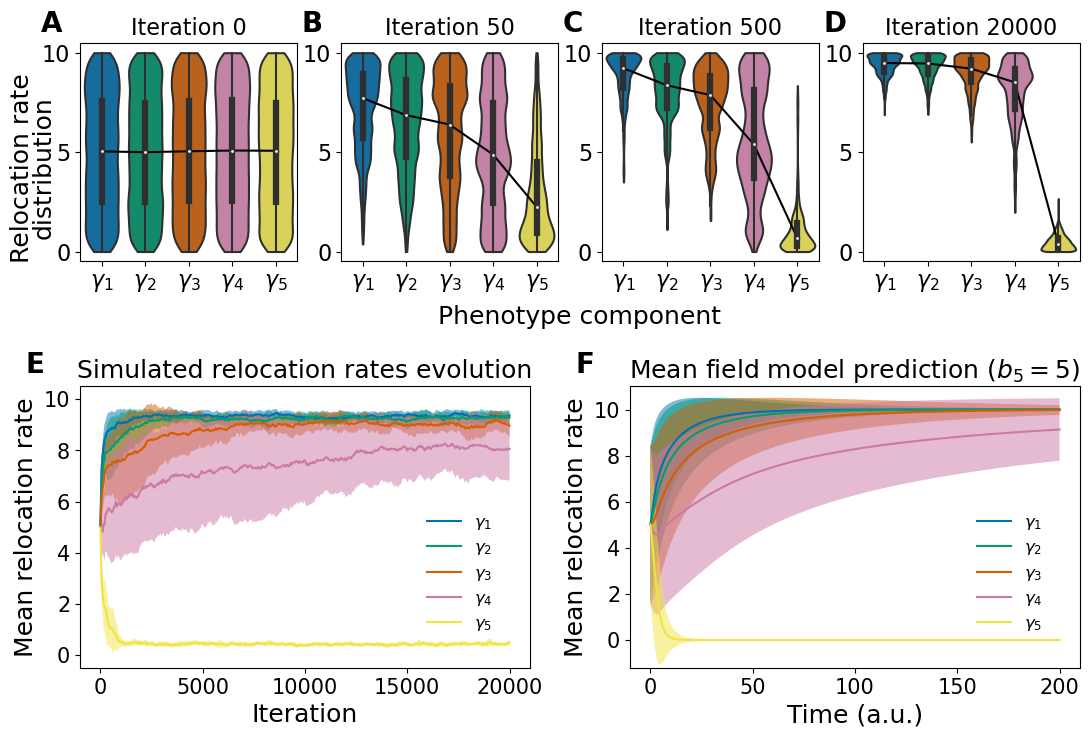

In [5]:
# This cell requires simulation data
df = []
for i in ['00', 50, 500, 20000]:
    data = [[] for _ in range(20)]
    boxdata = []
    for j in range(20):
        try:
            with open("./evolve_data/2021_04_08_21_48/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    df.append(pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=(
        '$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$')))

fig, ax = plt.subplots(ncols=4, nrows=1,
                       gridspec_kw=dict(width_ratios=[1, 1, 1, 1], left=0, right=1, top=1, bottom=0.65), figsize=(10, 6.25), dpi=100)

for i in range(4):
    ax[i].plot(df[i].median(), color='k', label='Simulated')
    sns.violinplot(data=df[i], scale='width', inner='box', cut=0, ax=ax[i])
    ax[i].text(-0.18, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes,
               size=20, weight='bold')
    ax[i].set_title('Iteration {}'.format(
        [0, 50, 500, 20000][i]), fontsize=16)
#     ax[0, i].set_xlabel("Phenotype component", fontsize=12)
    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
#     if i == 0:
#         ax[ i].set_ylabel("Relocation rate distribution",
#                             color=color, fontsize=12)
fig.text(-0.07, 0.8, 'Relocation rate',
         fontsize=18, va='center', rotation='vertical')
fig.text(-0.048, 0.8, 'distribution',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, 0.55, 'Phenotype component', fontsize=18, ha='center')
# get data for 20 trials plot below
iteration =20001
var_standard=[[] for _ in range(len(range(0,iteration,50)))]
ave_standard=[[] for _ in range(len(range(0,iteration,50)))]
for i in range(0,iteration,50):
    data=[[] for _ in range(20)]

    boxdata=[]
    for j in range(20):
        try:
            with open("./evolve_data/2021_04_08_21_48/trial_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
    var_standard[int(i/50)]=np.var(np.array(boxdata).T,1)
    ave_standard[int(i/50)]=np.average(np.array(boxdata).T,1)

# gs = ax[1, 0].get_gridspec()
# for i in range(4):
#     ax[1, i].remove()
gs2 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0, right=0.45, top=0.45, bottom=0)
# axbig = plt.subplot(gs2[0, 0])
# axbig = fig.add_subplot(gs2[1, :2])
axbig = fig.add_subplot(gs2[0, 0])
gs3 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0.55, right=1, top=0.45, bottom=0)
# axbig2 = fig.add_subplot(gs[1, 2:])
axbig2 = fig.add_subplot(gs3[0, 0])
for i in range(5):
    axbig.plot(np.linspace(0, 20000, 401), np.array(ave_standard)[
               :, i], '-', label="$\gamma_{}$".format(i+1))
    axbig.fill_between(np.linspace(0, 20000, 401), np.array(ave_standard)[
                       :, i]-np.sqrt(np.array(var_standard))[:, i], np.array(ave_standard)[:, i]+np.sqrt(np.array(var_standard))[:, i], alpha=0.5)
axbig.set_ylabel('Mean relocation rate', fontsize=18)
axbig.set_xlabel('Iteration', fontsize=18)
axbig.set_title('Simulated relocation rates evolution', fontsize=18)
axbig.legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.07), frameon=False, fontsize=12)
axbig.set_ylim(-0.5, 10.5)
axbig.set_xticks([0, 5000, 10000, 15000, 20000])
axbig.set_yticks([0, 2, 4, 6, 8, 10])
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)
axbig.text(-0.12, 1.05, 'E', transform=axbig.transAxes,
           size=20, weight='bold')
for i in range(5):
    axbig2.plot(t_eval, np.array(ave_meanfield)[
                :, i], label="$\gamma_{}$".format(i+1))
    axbig2.fill_between(t_eval, np.array(ave_meanfield)[:, i]-np.array(std_meanfield)[
                        :, i], np.array(ave_meanfield)[:, i]+np.array(std_meanfield)[:, i], alpha=0.5)
axbig2.set_ylabel('Mean relocation rate', fontsize=18)
axbig2.set_xlabel('Time (a.u.)', fontsize=18)
axbig2.set_title('Mean field model prediction ($b_5=5$)', fontsize=18)
axbig2.legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.07), frameon=False, fontsize=12)
axbig2.set_xticks([0, 50, 100, 150, 200])
axbig2.set_yticks([0, 2, 4, 6, 8, 10])
axbig2.set_ylim(-1.2, 11)
axbig2.tick_params(axis='x', labelsize=15)
axbig2.tick_params(axis='y', labelsize=15)
axbig2.text(-0.12, 1.05, 'F', transform=axbig2.transAxes,
            size=20, weight='bold')
fig.savefig('./Figures/Figure_2_evolution_dynamics.pdf', bbox_inches='tight')

# Figure 3: Transition and phase plane
## c=0

In [6]:
iteration =20001
b5_stochastic=[3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25] # uniform
mean_stochastic=[]
std_stochastic=[]
for b5 in b5_stochastic:
    var_stochastic=[]
    ave_stochastic=[]
    for i in range(18000,iteration,50): # last 5000 iterations average
        data=[[] for _ in range(20)]
        boxdata=[]
        for j in range(20):
            try:
                with open("./evolve_data/b5_c_plane/detailed/b5_{}_c_0/trial_{}/iteration_{}".format(b5,j,i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
        var_stochastic.append(np.var(np.array(boxdata).T,1))
        ave_stochastic.append(np.average(np.array(boxdata).T,1))
    
    mean_stochastic.append(np.average(np.array(ave_stochastic).T[3,:]))
    std_stochastic.append(np.average(np.sqrt(np.array(var_stochastic)).T[3,:]))


In [7]:
import scipy.optimize as opt
def func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x-d) )) + b


mean_meanfield=[4.3537649780099636e-07, 1.2442809856908339e-05, 0.000275648194462655, 0.0051376398503534685, 0.09980304760631943, 1.9433539737926002, 5.923982336165603, 7.116477747615005, 7.640762716048869, 7.98692993811066, 8.279261452257757, 4.782708437632432]
std_meanfield=[0.000906983985114219, 0.00491239697125021, 0.0235441577903079, 0.10736058816968916, 0.5599859665291492, 2.561692737833099, 2.2564125302822235, 1.5702422994556449, 1.2749981573429414, 1.146810224516724, 1.106891476140216, 2.718991766960965]
b5_meanfield=[3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 4.4]
(a_s, b_s, c_s,d_s), _ = opt.curve_fit(func, b5_stochastic,mean_stochastic,p0=[0,1,1,1])
(a_m, b_m, c_m,d_m), _ = opt.curve_fit(func, b5_meanfield,mean_meanfield,p0=[0,1,1,1])

## c=0.5

In [8]:
iteration =20001
b5_stochastic_exp=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # uniform
mean_stochastic_exp=[]
std_stochastic_exp=[]
for b5 in b5_stochastic_exp:
    var_stochastic=[]
    ave_stochastic=[]
    for i in range(18000,iteration,50): # last 5000 iterations average
        data=[[] for _ in range(20)]
        boxdata=[]
        for j in range(20):
            try:
                with open("./evolve_data/b5_c_plane/detailed/b5_{}_c_0.5/trial_{}/iteration_{}".format(b5,j,i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
        var_stochastic.append(np.var(np.array(boxdata).T,1))
        ave_stochastic.append(np.average(np.array(boxdata).T,1))
    
    mean_stochastic_exp.append(np.average(np.array(ave_stochastic).T[3,:]))
    std_stochastic_exp.append(np.average(np.sqrt(np.array(var_stochastic)).T[3,:]))

In [9]:
import scipy.optimize as opt
def func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x-d) )) + b
mean_meanfield_exp=[4.569717018891358e-09, 6.0368153131970736e-06, 0.004372515661512843, 1.2925613773924414, 4.842727340273152, 7.630972873699262, 8.830223403547468, 9.292050448738056, 9.531059476460602]
std_meanfield_exp=[9.056691919526321e-05, 0.003401920140112634, 0.10223646535084566, 2.435244137570728, 3.4386777382944786, 2.3881626669638134, 1.5916662104898822, 1.2087140726048455, 0.971031429326318]
b5_meanfield_exp=[4, 6, 8, 10, 10.8, 12, 14, 16, 18]
(a_s, b_s, c_s,d_s), _ = opt.curve_fit(func, b5_stochastic_exp,mean_stochastic_exp,p0=[0,1,1,1])
(a_m, b_m, c_m,d_m), _ = opt.curve_fit(func, b5_meanfield_exp,mean_meanfield_exp,p0=[0,1,1,1])


## Phase plane
### Stochastic

In [10]:
ave = []
for c in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for b5 in [3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16]:
        boxdata = []
        for i in range(20):
            data = [[] for _ in range(20)]
            try:
                with open("./evolve_data/b5_c_plane/b5_{}_c_{}/trial_{}/iteration_{}".format(b5, c, i, 20000), "rb") as fp:   # Unpickling
                    data[i] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(
                    np.array([data[i][j].hop for j in range(500)]), axis=0))

        ave.append(np.average(np.array(boxdata).T, 1))


def deri(b5):
    def max_eigen(h4):
        b = [0, 1, 2, 3, b5]
        h = [10, 10, 10, h4, 0.01]
        m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                      for j in range(5)])-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, 5, dx=1e-8).real


root_b5_5 = []

for c in np.linspace(-0.1, 0.7, 80):
    p = [np.exp(-i*c) for i in range(1, 6)]
    w = p/np.sum(p)
    root_b5_5.append(root(deri, 4, method='df-sane').x)

/home/tong/anaconda3/envs/evolution/lib/python3.9/site-packages/scipy/optimize/_spectral.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_k = np.vdot(s_k, s_k) / np.vdot(s_k, y_k)


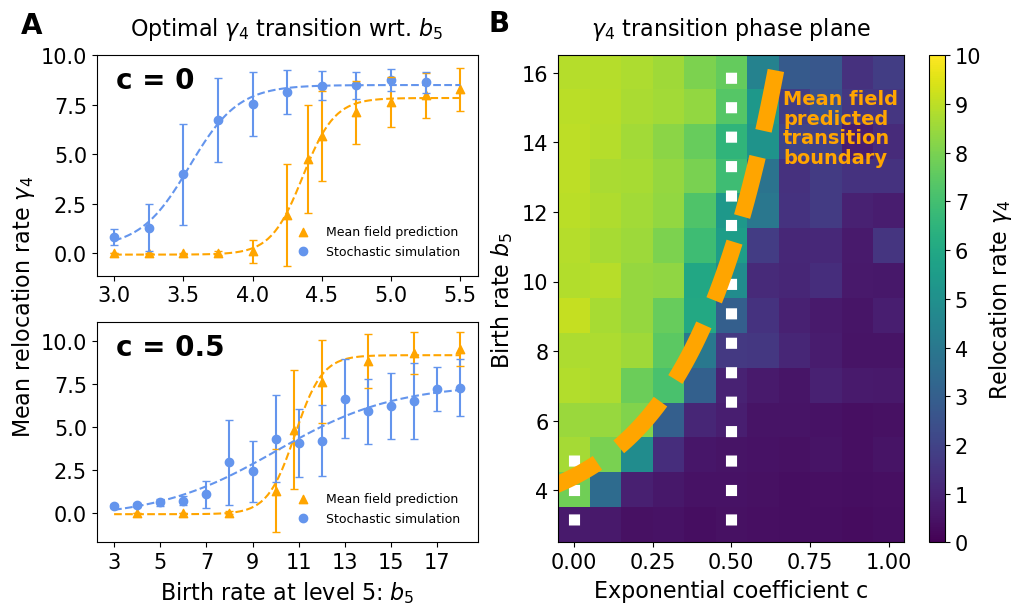

In [11]:
# color to be distinct from colorbar, warm color

fig, ax = plt.subplots(2, 2, constrained_layout=True,
                       gridspec_kw=dict(width_ratios=[1.1, 1], height_ratios=[1, 1]), figsize=(10, 6), dpi=100)
gs = ax[1, 0].get_gridspec()
for i in range(2):
    ax[i, 1].remove()
axbig = fig.add_subplot(gs[:, 1])

(a_s, b_s, c_s, d_s), _ = opt.curve_fit(
    func, b5_stochastic, mean_stochastic, p0=[0, 1, 1, 1])
(a_m, b_m, c_m, d_m), _ = opt.curve_fit(
    func, b5_meanfield, mean_meanfield, p0=[0, 1, 1, 1])

color_mf = 'orange'
color_sc = 'cornflowerblue'

ax[0, 0].scatter(b5_meanfield, mean_meanfield, marker='^',
                 color=color_mf, label='Mean field prediction')
ax[0, 0].errorbar(b5_meanfield, mean_meanfield, yerr=std_meanfield,
                  capsize=3, linestyle='None', color=color_mf)
ax[0, 0].plot(np.linspace(3, 5.5, 100), [func(i, a_m, b_m, c_m, d_m)
                                         for i in np.linspace(3, 5.5, 100)], '--', color=color_mf)

ax[0, 0].scatter(b5_stochastic, mean_stochastic,
                 label='Stochastic simulation', color=color_sc)
ax[0, 0].errorbar(b5_stochastic, mean_stochastic, yerr=std_stochastic,
                  capsize=3, linestyle='None', color=color_sc)
ax[0, 0].plot(np.linspace(3, 5.5, 100), [func(i, a_s, b_s, c_s, d_s)
                                         for i in np.linspace(3, 5.5, 100)], '--', color=color_sc)
ax[0, 0].tick_params(axis='x', labelsize=15)
ax[0, 0].tick_params(axis='y', labelsize=15)

ax[0, 0].legend(frameon=False, fontsize=9, loc='lower left',
                bbox_to_anchor=(0.48, 0.03))
ax[0, 0].set_title(
    "Optimal $\gamma_4$ transition wrt. $b_5$", fontsize=16, pad=15)
ax[0, 0].set_xticks([3, 3.5, 4, 4.5, 5, 5.5])
ax[0, 0].set_yticks([0, 2.5, 5, 7.5, 10])
ax[0, 0].text(-0.2, 1.1, 'A', transform=ax[0, 0].transAxes,
              size=20, weight='bold')
ax[0, 0].text(0.05, 0.85, 'c = 0', transform=ax[0, 0].transAxes,
              size=20, weight='bold')
(a_s, b_s, c_s, d_s), _ = opt.curve_fit(
    func, b5_stochastic_exp, mean_stochastic_exp, p0=[0, 1, 1, 1])
(a_m, b_m, c_m, d_m), _ = opt.curve_fit(
    func, b5_meanfield_exp, mean_meanfield_exp, p0=[0, 1, 1, 1])

ax[1, 0].scatter(b5_meanfield_exp, mean_meanfield_exp, marker='^',
                 color=color_mf, label='Mean field prediction')
ax[1, 0].errorbar(b5_meanfield_exp, mean_meanfield_exp,
                  yerr=std_meanfield_exp, capsize=3, linestyle='None', color=color_mf)
ax[1, 0].plot(np.linspace(3, 18, 100), [func(i, a_m, b_m, c_m, d_m)
                                        for i in np.linspace(3, 18, 100)], '--', color=color_mf)

ax[1, 0].scatter(b5_stochastic_exp, mean_stochastic_exp,
                 label='Stochastic simulation', color=color_sc)
ax[1, 0].errorbar(b5_stochastic_exp, mean_stochastic_exp,
                  yerr=std_stochastic_exp, capsize=3, linestyle='None', color=color_sc)
ax[1, 0].plot(np.linspace(3, 18, 100), [func(i, a_s, b_s, c_s, d_s)
                                        for i in np.linspace(3, 18, 100)], '--', color=color_sc)

ax[1, 0].tick_params(axis='x', labelsize=15)
ax[1, 0].tick_params(axis='y', labelsize=15)

ax[1, 0].legend(frameon=False, fontsize=9, loc='lower left',
                bbox_to_anchor=(0.48, 0.03))

ax[1, 0].set_yticks([0, 2.5, 5, 7.5, 10])
ax[1, 0].set_xlabel('Birth rate at level 5: $b_5$', fontsize=16, labelpad=5)
ax[1, 0].set_xticks([3, 5, 7, 9, 11, 13, 15, 17])
ax[1, 0].text(0.05, 0.85, 'c = 0.5', transform=ax[1, 0].transAxes,
              size=20, weight='bold')

fig.text(-0.005, 0.5, 'Mean relocation rate $\gamma_4$',
         fontsize=16, va='center', rotation='vertical')

axbig.set_xlim(-0.05, 1.05)
axbig.set_ylim(2.5, 16.5)
im = axbig.imshow(np.array(ave)[:, -2].reshape(11, 14).T, interpolation='none',
                  extent=[-0.05, 1.05, 2.5, 16.5], aspect='auto', origin='lower')
axbig.plot(np.linspace(-0.1, 0.7, 80), np.array(root_b5_5),
           '--', color='orange', linewidth=12)

axbig.set_xlabel('Exponential coefficient c', fontsize=16, labelpad=5)
axbig.set_ylabel('Birth rate $b_5$', fontsize=16, labelpad=5)

cbar = fig.colorbar(im, ticks=np.linspace(-1, 10, 12), aspect=30)
cbar.mappable.set_clim(0, 10)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Relocation rate $\gamma_4$', fontsize=16)
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)
axbig.vlines(x=0, ymin=3, ymax=5.5, color='w',
             linestyles='dotted', linewidth=8)
axbig.vlines(x=0.5, ymin=3, ymax=18, color='w',
             linestyles='dotted', linewidth=8)
axbig.text(-0.2, 1.05, 'B', transform=axbig.transAxes,
           size=20, weight='bold')
# axbig.text(0.54, 0.65, 'Mean field predicted', transform=axbig.transAxes,
#            size=9.5,color=color_mf, weight='bold')
# axbig.text(0.54, 0.62, 'transition boundary', transform=axbig.transAxes,
#            size=9.5,color=color_mf, weight='bold')

axbig.text(0.65, 0.9, 'Mean field', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.86, 'predicted', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.82, 'transition', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.78, 'boundary', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')

axbig.set_title("$\gamma_4$ transition phase plane", fontsize=16, pad=15)

fig.savefig('./Figures/Figure_3_transition.pdf', bbox_inches='tight')

### Mean field (supplementary?)

4.385056888355387
2.99999173026448


/home/tong/anaconda3/envs/evolution/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


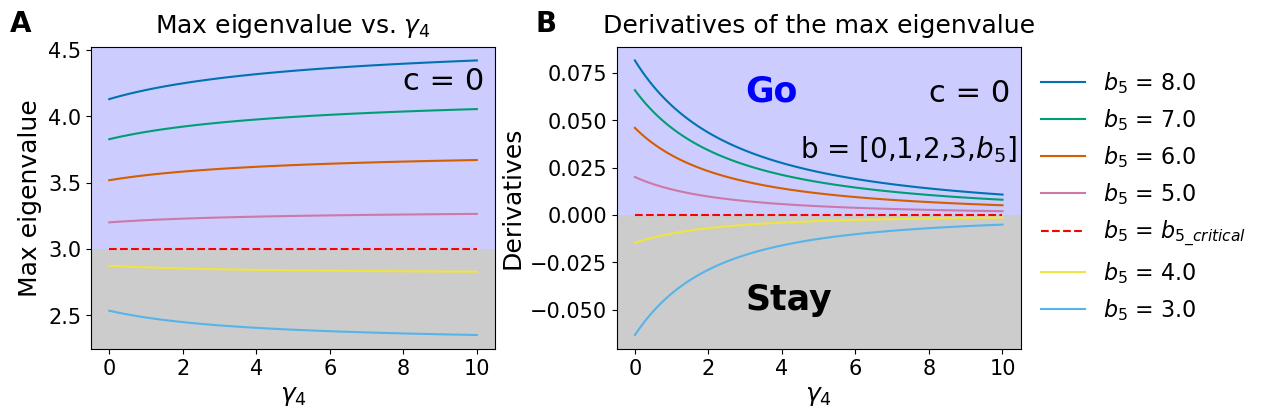

In [17]:
def deri(h4):
    def max_eigen(h4):
        b = [0, 1, 2, 3, b5]
        h = [10, 10, 10, h4, 0.001]
        m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                      for j in range(5)])-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, h4, dx=1e-8).real
def deri_root(b5):
    def max_eigen(h4):
        b = [0, 1, 2, 3, b5]
        h = [10, 10, 10, h4, 0.001]
        m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                      for j in range(5)])-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, 5, dx=1e-8).real
def max_eigen(h4):
    b = [0, 1, 2, 3, b5]
    h = [10, 10, 10, h4, 0.001]
    m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                  for j in range(5)])-np.diag(h)
    return np.max(LA.eig(m)[0])
c = 0
p = [np.exp(-i*c) for i in range(1, 6)]
w = p/np.sum(p)

fig,ax = plt.subplots(1,2,dpi=100,figsize=(12,4),gridspec_kw=dict(width_ratios=[1, 1],wspace=0.3))
b5=root(deri_root, 4, method='df-sane').x
max_eigen_critial=max_eigen(5)
print(b5)
print(max_eigen_critial)
for b5 in np.linspace(3, 8, 6)[::-1]:
    maxeign = []
    for h4 in np.linspace(0, 10, 100):
        maxeign.append(max_eigen(h4))
    ax[0].plot(np.linspace(0, 10, 100), maxeign,
            label='$b_5$ = {}'.format(b5))
    if b5 == 5:
        ax[0].plot(np.linspace(0, 10, 100), [max_eigen_critial]*100, '--r', label='$b_5$ = $b_{5\_critical}$')
        
# ax[0].legend(frameon=False, fontsize=18,
#           loc='lower left', bbox_to_anchor=(1, -0.03))
ax[0].set_ylim(*ax[0].get_ylim())
ax[0].axhspan(3.0017180476774152, ax[0].get_ylim()[-1], facecolor='blue', alpha=0.2)
ax[0].axhspan(ax[0].get_ylim()[0], 3.0017180476774152, facecolor='black', alpha=0.2)
# ax[0].legend(frameon=False, fontsize=18,
#           loc='lower left', bbox_to_anchor=(1, -0.03))
ax[0].text(8, 4.2, 'c = 0', fontsize=22)
# ax[0].text(5,3.35, 'Go', fontsize=25,color='blue',weight='bold')
# ax[0].text(5, 2.5, 'Stay', fontsize=25,color='black',weight='bold')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title('Max eigenvalue vs. $\gamma_4$',
             fontsize=18, pad=10)
ax[0].set_xlabel('$\gamma_4$', fontsize=18)
ax[0].set_ylabel('Max eigenvalue', fontsize=18)
ax[0].text(-0.2, 1.05, 'A', transform=ax[0].transAxes,
           size=20, weight='bold')



for b5 in np.linspace(3, 8, 6)[::-1]:
    derivatives = []
    for h4 in np.linspace(0, 10, 100):
        derivatives.append(deri(h4))
    ax[1].plot(np.linspace(0, 10, 100), derivatives,
            label='$b_5$ = {}'.format(b5))
    if b5 == 5:
        ax[1].plot(np.linspace(0, 10, 100), [
                0]*100, '--r', label='$b_5$ = $b_{5\_critical}$')
ax[1].set_ylim(*ax[1].get_ylim())
ax[1].axhspan(0, ax[1].get_ylim()[-1], facecolor='blue', alpha=0.2)
ax[1].axhspan(ax[1].get_ylim()[0], 0, facecolor='black', alpha=0.2)
ax[1].legend(frameon=False, fontsize=16,
          loc='lower left', bbox_to_anchor=(1, 0.02))
ax[1].text(8, 0.06, 'c = 0', fontsize=22)
ax[1].text(4.5, 0.03, 'b = [0,1,2,3,$b_5$]', fontsize=20)
ax[1].text(3, 0.06, 'Go', fontsize=25,color='blue',weight='bold')
ax[1].text(3, -0.05, 'Stay', fontsize=25,color='black',weight='bold')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title('Derivatives of the max eigenvalue',
             fontsize=18, pad=10)
ax[1].text(-0.2, 1.05, 'B', transform=ax[1].transAxes,
           size=20, weight='bold')
plt.xlabel('$\gamma_4$', fontsize=18)
plt.ylabel('Derivatives', fontsize=18)

fig.savefig('./Figures/Supplementary_max_eigen.pdf', bbox_inches='tight')

# Figure 4: high density
## Stochastic simulation

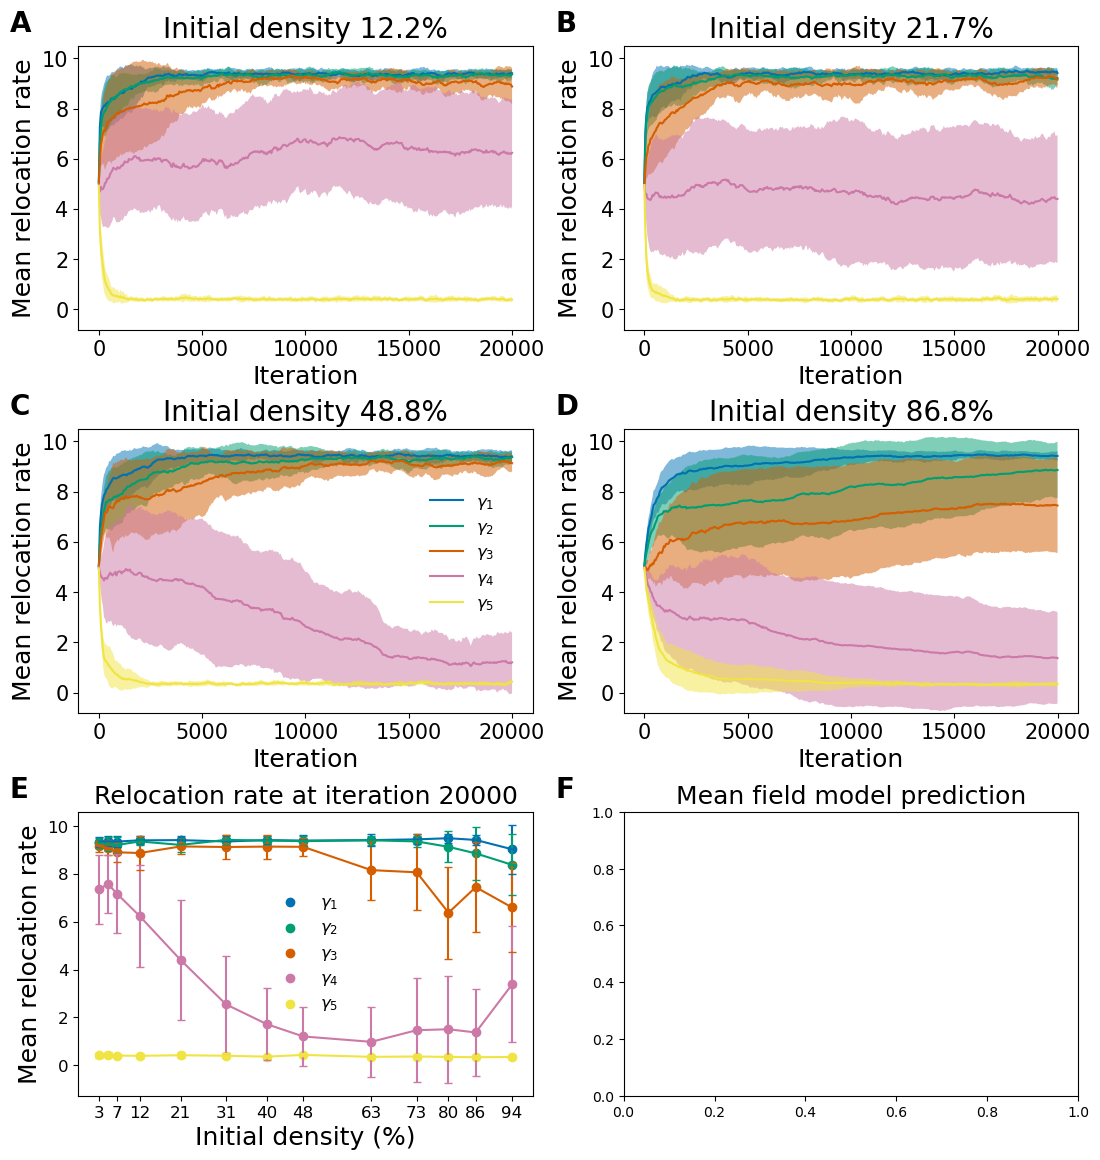

In [18]:
fig, ax = plt.subplots(3, 2, gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1, 1], left=0, right=1, top=1, bottom=0, hspace=0.35, wspace=0.2), dpi=100, figsize=(10, 10.5))
iter_interval = 50
for k in range(4):
    density = [12, 21, '48_rerun_2', 86][k]
    density_ = [12.2, 21.7, 48.8, 86.8][k]
    iteration = 20001
    var = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    ave = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    for i in range(0, iteration, iter_interval):
        data = [[] for _ in range(20)]

        boxdata = []
        for j in range(20):
            try:
                with open("./evolve_data/high_density/density_{}/trial_{}/iteration_{}".format(density, j, i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(
                    np.array([data[j][i].hop for i in range(500)]), axis=0))
    #     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
        var[int(i/iter_interval)] = np.var(np.array(boxdata).T, 1)
        ave[int(i/iter_interval)] = np.average(np.array(boxdata).T, 1)

    for i in range(5):
        ax[k//2, k % 2].plot(np.linspace(0, 20000, int(np.ceil(iteration/iter_interval))),
                             np.array(ave)[:, i], '-', label="$\gamma_{}$".format(i+1))
        ax[k//2, k % 2].fill_between(np.linspace(0, 20000, int(np.ceil(iteration/iter_interval))), np.array(
            ave)[:, i]-np.sqrt(np.array(var))[:, i], np.array(ave)[:, i]+np.sqrt(np.array(var))[:, i], alpha=0.5)
        if k == 2:
            ax[k//2, k % 2].legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.3), frameon=False, fontsize=12)
    ax[k//2, k % 2].set_ylabel('Mean relocation rate', fontsize=18)
    ax[k//2, k % 2].set_xlabel('Iteration', fontsize=18)
    ax[k//2, k % 2].set_title('Initial density {}%'.format(density_),
                              fontsize=20)
    ax[k//2, k % 2].text(-0.15, 1.05, string.ascii_uppercase[k], transform=ax[k//2, k % 2].transAxes,
                         size=20, weight='bold')
    ax[k//2, k % 2].set_ylim(-0.8, 10.5)
    ax[k//2, k % 2].set_xticks([0, 5000, 10000, 15000, 20000])
    ax[k//2, k % 2].tick_params(axis='x', labelsize=15)
    ax[k//2, k % 2].tick_params(axis='y', labelsize=15)
    


ave_density = []
std_density = []
density = [int(50000/n/n)
           for n in [128, 96, 80, 64, 48, 40, 35, 32, 28, 26, 25, 24, 23]]
for i in density:
    data = [[] for _ in range(20)]
    boxdata = []
    if i == 48:
        i = '48_rerun_2'
    for j in range(20):
        try:
            with open("./evolve_data/high_density/density_{}/trial_{}/iteration_20000".format(i, j), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.average(
                np.array([data[j][i].hop for i in range(500)]), axis=0))
    std_density.append(np.std(np.array(boxdata).T, 1))
    ave_density.append(np.average(np.array(boxdata).T, 1))

for i in range(5):
    ax[2, 0].scatter(density, np.array(ave_density)[:, i],
                     label="$\gamma_{}$".format(i+1))
    ax[2, 0].errorbar(density, np.array(ave_density)[:, i],
                      yerr=np.array(std_density)[:, i], capsize=3)
ax[2, 0].set_xticks([3, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94])
ax[2, 0].tick_params(axis='both', which='major', labelsize=12)
ax[2, 0].set_xlabel('Initial density (%)', fontsize=18)
ax[2, 0].set_ylabel('Mean relocation rate', fontsize=18)
ax[2, 0].set_title('Relocation rate at iteration 20000', fontsize=18)
ax[2, 0].text(-0.15, 1.05, 'E', transform=ax[2, 0].transAxes,
              size=20, weight='bold')
ax[2, 0].legend(frameon=False, fontsize=12)

ax[2, 1].set_title('Mean field model prediction', fontsize=18)
ax[2, 1].text(-0.15, 1.05, 'F', transform=ax[2, 1].transAxes,
              size=20, weight='bold')
fig.savefig('./Figures/Figure_4_density.pdf', bbox_inches='tight')

### coexistence of phenotypes at intermidiate density levels (supplementary)

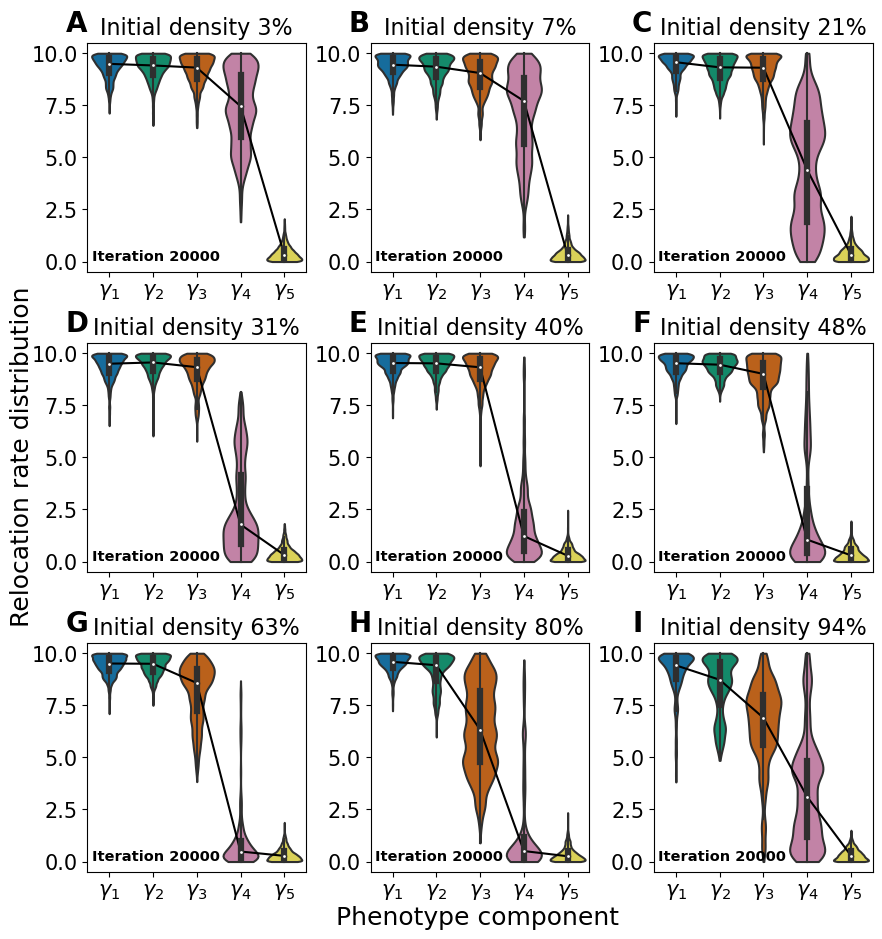

In [20]:
# coexistence of phenotypes on density 21% 31% violin plots
df = []
for i in [3,7,21, 31,40,48,63,80,94]:
    data = [[] for _ in range(20)]
    boxdata = []
    for j in range(20):
        try:
            with open("./evolve_data/high_density/density_{}/trial_{}/iteration_20000".format(i, j), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    df.append(pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=(
        '$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$')))
fig, ax = plt.subplots(ncols=3, nrows=3, constrained_layout=True,dpi=100,figsize=(8.5,9))

for i in range(9):
    ax[i//3,i%3].plot(df[i].median(), color='k', label='Simulated')
    sns.violinplot(data=df[i], scale='width', inner='box', cut=0, ax=ax[i//3,i%3])
    ax[i//3,i%3].text(-0.1, 1.05, string.ascii_uppercase[i], transform=ax[i//3,i%3].transAxes,
               size=20, weight='bold')
    ax[i//3,i%3].text(0.02, 0.05, "Iteration 20000", transform=ax[i//3,i%3].transAxes,
               size=10.5, weight='bold')
    ax[i//3,i%3].set_title('Initial density {}%'.format([3,7,21, 31,40,48,63,80,94][i]), fontsize=16)
    ax[i//3,i%3].tick_params(axis='x', labelsize=15)
    ax[i//3,i%3].tick_params(axis='y', labelsize=15)
#     ax[i//3,i%3].set_xlabel("Phenotype component", fontsize=12)
#     ax[i//3,i%3].set_ylabel("Relocation rate distribution",
#                      color=color, fontsize=12)
fig.text(-0.02, 0.5, 'Relocation rate distribution',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.53, -0.02, 'Phenotype component', fontsize=18, ha='center')
fig.savefig('./Figures/Supplementary_coexistence.pdf', bbox_inches='tight')

In [ ]:
# k on initial conditions

In [21]:
# supplementary figures

# first 2 eigenvalues

# mean field high density 3, 12, 21/31, 48

# occupancy after catastrophe for different densities to see high occupancy on high resource levels, dynamics scarcity of site introduced by density, compared to the built-in exponential resource

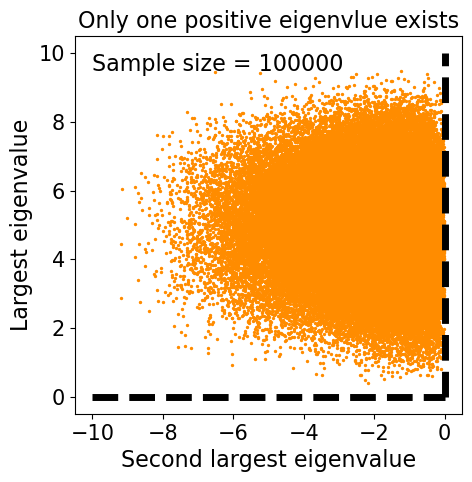

In [33]:
b = [0, 1, 2, 3, 4]
c = 0
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0)

def max_eigen2(h):
    """Compactly generate coefficient matrix and calculate the largest two eigenvalues"""
    m = np.outer(w, np.array(b)+np.array(h))-np.diag(h)
    return np.sort(LA.eig(m)[0])[-2:][::-1]


def plot_largest2eigenvalues(sample_size=100000, random_birth_rate=False):
    """Plot the scatter plot of the largest 2 eigenvalues for randomly generated hopping rate with or without random birth rate"""
    eign = []
    for i in range(sample_size):
        if random_birth_rate:
            global b
            b = np.random.rand(5)*10
        eign.append(max_eigen2(np.random.rand(5)*10))
    fig=plt.figure(dpi=100,figsize=(5,5))
    ax=plt.subplot()
    sc=ax.scatter(np.array(eign)[:, 1], np.array(eign)[:, 0], s=2,color='darkorange')
    ax.vlines(0, 0, 10, linestyles='dashed',lw=5,color='k')
    ax.hlines(0, -10, 0, linestyles='dashed',lw=5,color='k')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title('Only one positive eigenvlue exists',fontsize=16)
    ax.text(-10,9.5,'Sample size = {}'.format(sample_size),fontsize=16)
#     cbar=plt.colorbar(sc,aspect=20)
    
#     cbar.mappable.set_clim(-10,0)
#     cbar.set_label('Third largest eigenvalue',fontsize=16)
#     cbar.ax.tick_params(labelsize=15)
    plt.xlabel("Second largest eigenvalue", fontsize=16)
    plt.ylabel("Largest eigenvalue", fontsize=16)
    fig.savefig('./Figures/Supplementary_eigenvalues.pdf', bbox_inches='tight')
    plt.show()

# b=[4,3,6,6,0]
plot_largest2eigenvalues(sample_size=100000,random_birth_rate=True)

## Site occupancy

In [23]:
def get_num(a, n):
    """
    Efficiently count agent numbers at all the sites

        Parameters: 
            a (list or array): list of agent object;
            n (int): size of the square environment
       Return:
            2-d numpy array: entry at i,j represents the number of agent at location (i,j)
    """
    num = np.zeros((n, n), dtype=int)
    for pos in [a[i].__dict__['pos'] for i in range(len(a))]:
        num[pos] += 1
    return num


size = 32
density = 48
meanoccupancy = []
stdoccupancy = []
for size, density in [(128, 3),
                      (96, 5),
                      (80, 7),
                      (64, 12),
                      (48, 21),
                      (40, 31),
                      (35, 40),
                      (32, 48),
                      (28, 63),
                      (26, 73),
                      (25, 80),
                      (24, 86),
                      (23, 94)]:
    # [(128,3),(80,7),(64,12),(48,21),(32,48),(25,80),(23,94)]:
    with open("./evolve_data/high_density/density_{}/trial_{}/resource.txt".format(density, 0), "rb") as fp:   # Unpickling
        resource = pickle.load(fp)[:size, :size]
    empty_array = np.empty((size, size))
    empty_array[:] = np.NaN
    occupancy = []
    for iteration in range(18000, 20001, 50):
        unoccupied_trial = []
        for j in range(20):
            with open("./evolve_data/high_density/density_{}/trial_{}/iteration_{}".format(density, j, iteration), "rb") as fp:   # Unpickling
                data = pickle.load(fp)
            unoccupied = np.where(get_num(data, size), empty_array, resource)
            unoccupied_trial.append(np.bincount([int(i) for i in unoccupied.flatten(
            ) if not np.isnan(i)], minlength=5)/np.bincount(resource.flatten(), minlength=5))
        occupancy.append(np.mean(unoccupied_trial, 0))
    meanoccupancy.append(np.mean(np.array(occupancy), 0))
    stdoccupancy.append(np.std(np.array(occupancy), 0))

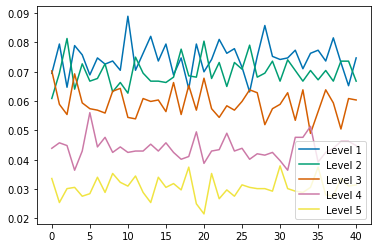

In [24]:
for i in range(5):
    plt.plot(np.array(occupancy)[:,i],label='Level {}'.format(i+1))
plt.legend()

In [25]:
# for i in range(13):
#     fig,ax=plt.subplots(dpi=100)
#     bp=ax.bar([0,1,2,3,4],meanoccupancy[i])
#     plt.ylim(0,1)
#     plt.text(1,0.2,'Initial density = {}'.format([(128, 3),
#                       (96, 5),
#                       (80, 7),
#                       (64, 12),
#                       (48, 21),
#                       (40, 31),
#                       (35, 40),
#                       (32, 48),
#                       (28, 63),
#                       (26, 73),
#                       (25, 80),
#                       (24, 86),
#                       (23, 94)][i][1]),fontsize=20)
#     ax.bar_label(bp)
#     ax.set_xlabel("Resource levels",fontsize=16)
#     ax.set_ylabel("Percentage of unoccupied sites",fontsize=16)
#     plt.show()

In [26]:
err_ratio = [meanoccupancy[i][-1]/meanoccupancy[i][0]*np.sqrt((stdoccupancy[i][-1]/meanoccupancy[i][-1])**2+(stdoccupancy[i][0]/meanoccupancy[i][0])**2) for i in range(13)]

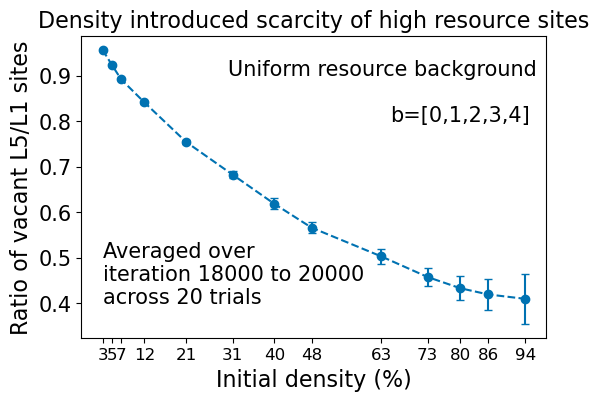

In [27]:
fig,ax=plt.subplots(dpi=100)
ax.scatter([3, 5, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94],[meanoccupancy[i][-1]/meanoccupancy[i][0] for i in range(13)])
ax.errorbar([3, 5, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94],[meanoccupancy[i][-1]/meanoccupancy[i][0] for i in range(13)],
                  yerr=err_ratio, capsize=3, linestyle='--')
ax.set_xticks([3, 5, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94]);
ax.set_xlabel('Initial density (%)',fontsize=16)
ax.set_ylabel('Ratio of vacant L5/L1 sites',fontsize=16)
ax.set_title('Density introduced scarcity of high resource sites',fontsize=16)
ax.text(30,0.9,"Uniform resource background",fontsize=15)
ax.text(65,0.8,"b=[0,1,2,3,4]",fontsize=15)
ax.text(3,0.5,"Averaged over",fontsize=15)
ax.text(3,0.45,"iteration 18000 to 20000",fontsize=15)
ax.text(3,0.4,"across 20 trials",fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=15)
fig.savefig('./Figures/Supplementary_density_scarcity.pdf', bbox_inches='tight')

In [28]:
[(i,j) for i, j in zip([128,96,80,64,48,40,35,32,28,26,25,24,23],[int(50000/i/i) for i in [128,96,80,64,48,40,35,32,28,26,25,24,23]])]

[(128, 3),
 (96, 5),
 (80, 7),
 (64, 12),
 (48, 21),
 (40, 31),
 (35, 40),
 (32, 48),
 (28, 63),
 (26, 73),
 (25, 80),
 (24, 86),
 (23, 94)]

In [29]:
[int(50000/i/i) for i in [128,96,80,64,48,40,35,32,28,26,25,24,23]]

[3, 5, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94]

In [30]:
meanoccupancy

[array([0.98008768, 0.97902018, 0.97781724, 0.97232399, 0.93762516]),
 array([0.9640302 , 0.96180625, 0.95911524, 0.95202681, 0.89048835]),
 array([0.94741343, 0.94409719, 0.94048167, 0.92986972, 0.84502352]),
 array([0.91691752, 0.91291001, 0.90657501, 0.88169125, 0.77142557]),
 array([0.85036416, 0.84329924, 0.83448875, 0.75650584, 0.6415135 ]),
 array([0.7768052 , 0.77187144, 0.7566885 , 0.61321007, 0.53025892]),
 array([0.69648554, 0.68686139, 0.67057484, 0.48966175, 0.43076348]),
 array([0.61324749, 0.60646872, 0.58355146, 0.41573351, 0.34730787]),
 array([0.45887805, 0.45137921, 0.41793863, 0.24835327, 0.23093918]),
 array([0.33945993, 0.3307762 , 0.30157762, 0.18005163, 0.15544832]),
 array([0.27236789, 0.26043866, 0.2132254 , 0.13868293, 0.11805816]),
 array([0.18031843, 0.17212398, 0.15198031, 0.08606421, 0.07569972]),
 array([0.07456996, 0.06984479, 0.05932142, 0.04386825, 0.03058242])]

In [31]:
stdoccupancy

[array([0.0005038 , 0.00047812, 0.00055912, 0.00058845, 0.00061249]),
 array([0.00072511, 0.0009869 , 0.00077392, 0.00101033, 0.00144299]),
 array([0.00164761, 0.00130847, 0.00145056, 0.00193854, 0.00179663]),
 array([0.00189474, 0.00202922, 0.00205163, 0.00239892, 0.00255476]),
 array([0.00363393, 0.00369561, 0.00359037, 0.00334091, 0.00354133]),
 array([0.00479911, 0.00373324, 0.00405849, 0.00617563, 0.00528055]),
 array([0.00541284, 0.00685175, 0.00602085, 0.00755753, 0.00766762]),
 array([0.00697296, 0.00739903, 0.00776799, 0.00710541, 0.00604719]),
 array([0.00754705, 0.00835373, 0.0086475 , 0.00680138, 0.00644232]),
 array([0.00919221, 0.00771573, 0.00892141, 0.00688971, 0.00552804]),
 array([0.00929895, 0.00551264, 0.00732446, 0.00606002, 0.0058007 ]),
 array([0.00789664, 0.00577116, 0.00659194, 0.00548891, 0.00520082]),
 array([0.00541805, 0.00459903, 0.00481448, 0.00370569, 0.00346525])]